In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from joblib import Parallel, delayed
n_jobs = os.cpu_count() - 2
from tqdm.notebook import tqdm
import networkx as nx
import navis
from fafbseg import flywire
import flybrains
flywire.set_default_dataset("public")
import pickle
from scipy.stats import wilcoxon

def p_value_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# make matplotlib plots look better
plt.style.use('dark_background')

Default dataset set to "public".


In [2]:
# data
data_folder = '../../data/FlyWire/'
processed_data_folder = '../../processed_data/FlyWire/'
figure_folder = '../../processed_data/FlyWire/figures/'
files = os.listdir(data_folder)

In [3]:
skip_connections = True

for f in files:
    if f.endswith('.csv.gz'):
        file_name = f.split('.')[0]
        if skip_connections and 'connections' in file_name:
            continue
        command = file_name+"= pd.read_csv('"+ os.path.join(data_folder, f) +"')"
        exec(command)
        # print(command)

In [52]:
# target connections data
target_connections = 'connections_princeton_no_threshold'
connections = pd.read_csv(os.path.join(data_folder, target_connections + '.csv.gz'))

In [5]:
classification = classification.fillna('')

In [6]:
# get only ORNs
ORNs = classification.copy()
# drop nan in cell_type column
ORNs = ORNs.dropna(subset=['hemibrain_type','side'])
ORNs = ORNs[ORNs['hemibrain_type'].str.contains('ORN')]
left_ORNs = ORNs[ORNs['side']=='left'].copy()
right_ORNs = ORNs[ORNs['side']=='right'].copy()

In [7]:
# side distribution
# unique cell types
unique_ORN_types = np.unique(ORNs['hemibrain_type'])

print('Number of ORNs: ', len(ORNs))
print('Number of left ORNs: ', len(left_ORNs))
print('Number of right ORNs: ', len(right_ORNs))
print('Number of unique ORN types: ', len(unique_ORN_types))

Number of ORNs:  2276
Number of left ORNs:  1115
Number of right ORNs:  1132
Number of unique ORN types:  51


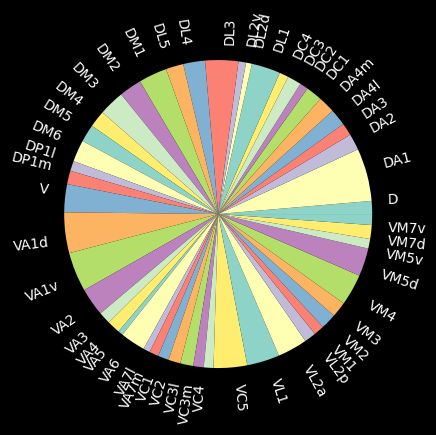

In [8]:
# make a pie chart of cell types
plt.figure(figsize=(5,5))
type_labels, counts = np.unique(ORNs['hemibrain_type'], return_counts=True)
# clean labels to remove the 'ORN' part
type_labels = [l.split('ORN_')[1] for l in type_labels]
plt.pie(counts, labels=type_labels, rotatelabels=True, textprops={'fontsize': 10})
plt.gca().set_aspect('equal')
plt.savefig(os.path.join(figure_folder, 'ORN_types_pie_chart.pdf'), dpi=300, bbox_inches='tight')
plt.show()


In [9]:
left_ORN_roots = [left_ORNs['root_id'].iloc[i] for i in range(len(left_ORNs))]
right_ORN_roots = [right_ORNs['root_id'].iloc[i] for i in range(len(right_ORNs))]

if os.path.exists(os.path.join(processed_data_folder, 'left_ORN_skeletons.pkl')):
    with open(os.path.join(processed_data_folder, 'left_ORN_skeletons.pkl'), 'rb') as f:
        left_ORN_skeletons = pickle.load(f)
else:
    left_ORN_skeletons = flywire.get_l2_skeleton(left_ORN_roots)
    # cache skeletons
    with open(os.path.join(processed_data_folder, 'left_ORN_skeletons.pkl'), 'wb') as f:
        pickle.dump(left_ORN_skeletons, f)

if os.path.exists(os.path.join(processed_data_folder, 'right_ORN_skeletons.pkl')):
    with open(os.path.join(processed_data_folder, 'right_ORN_skeletons.pkl'), 'rb') as f:
        right_ORN_skeletons = pickle.load(f)
else:
    right_ORN_skeletons = flywire.get_l2_skeleton(right_ORN_roots)
    # cache skeletons
    with open(os.path.join(processed_data_folder, 'right_ORN_skeletons.pkl'), 'wb') as f:
        pickle.dump(right_ORN_skeletons, f)

In [10]:
left_ORN_types = [left_ORNs['hemibrain_type'].iloc[i] for i in range(len(left_ORNs))]
right_ORN_types = [right_ORNs['hemibrain_type'].iloc[i] for i in range(len(right_ORNs))]

Plot neurons:   0%|          | 0/1115 [00:00<?, ?it/s]

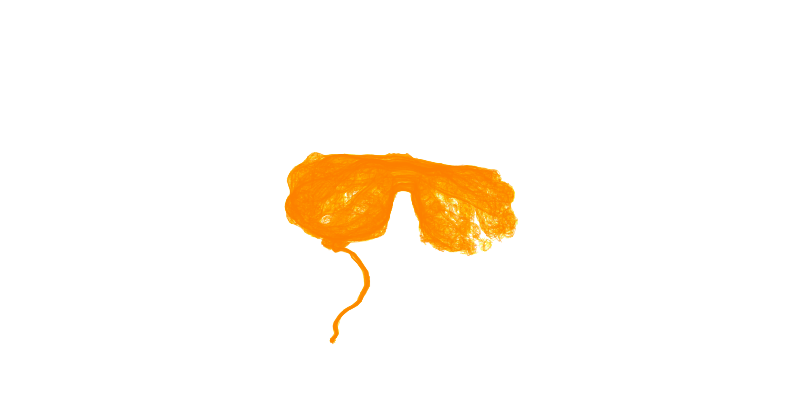

Plot neurons:   0%|          | 0/1132 [00:00<?, ?it/s]

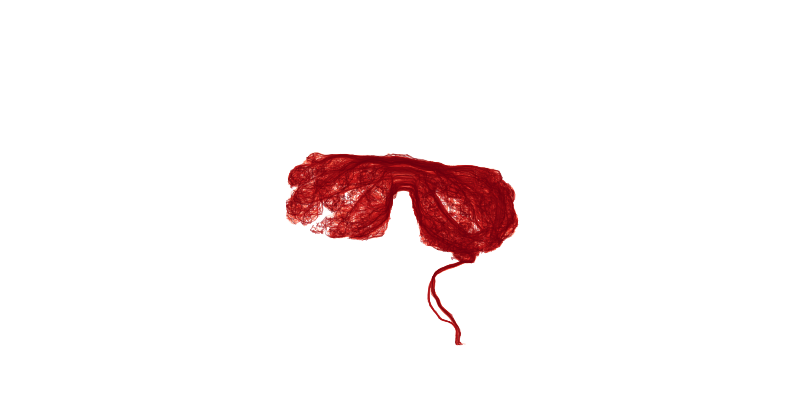

In [11]:
fig, ax = navis.plot2d(left_ORN_skeletons, alpha=0.5, lw=0.5, palette='Wistia', figsize=(10,10))
_ = navis.plot2d(flybrains.FLYWIRE, ax=ax, color='white', lw=0.5, alpha=0.1)
fig.patch.set_visible(False)
ax.patch.set_visible(False)
ax.azim = ax.elev = -90
ax.set_axis_off()
ax.grid(False)
ax.invert_yaxis()
plt.savefig(os.path.join(figure_folder, 'left_ORN_skeletons.pdf'), dpi=300, bbox_inches='tight')
plt.show()

fig, ax = navis.plot2d(right_ORN_skeletons, alpha=0.5, lw=0.5, palette='Reds', figsize=(10,10))
_ = navis.plot2d(flybrains.FLYWIRE, ax=ax, color='white', lw=0.5, alpha=0.1)
fig.patch.set_visible(False)
ax.patch.set_visible(False)
ax.azim = ax.elev = -90
ax.set_axis_off()
ax.grid(False)
ax.invert_yaxis()
plt.savefig(os.path.join(figure_folder, 'right_ORN_skeletons.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [12]:
def get_neurotransmitter(root_id, adjust_synapse_counts=True):
    # get the information from neurons table
    assert len(neurons[neurons['root_id']==root_id]) == 1
    nt = neurons[neurons['root_id']==root_id]['nt_type'].values[0]
    nt_conf = neurons[neurons['root_id']==root_id]['nt_type_score'].values[0]
    return nt, nt_conf

def get_neuropil_distribution(root_id, adjust_synapse_counts=True, relative_to=None):
    # get the connections
    connectivity = connections[connections['pre_root_id']==root_id]
    neuropils = connectivity['neuropil'].values

    # if adjust_synapse_counts, multiply neuropils by synapse counts to get the distribution
    if adjust_synapse_counts:
        synapse_counts = connectivity['syn_count'].values
        # multiply neuropils by synapse counts
        neuropils = np.repeat(neuropils, synapse_counts)
    
    # if relative_to is not None, adjust the neuropils to be marked ipsi or contra
    if relative_to is not None:
        assert relative_to in ['AL_L', 'AL_R']
        if relative_to == 'AL_L':
            neuropils = np.array([n.replace('_L','_ipsi') if '_L' in n else n.replace('_R','_contra') for n in neuropils])
        else:
            neuropils = np.array([n.replace('_R','_ipsi') if '_R' in n else n.replace('_L','_contra') for n in neuropils])
    
    # get the distribution
    neuropils, counts = np.unique(neuropils, return_counts=True)
    distribution = counts/np.sum(counts)
    
    return neuropils, distribution, counts

def get_downstream_cell_types(root_id, relative_to=None):
    # get the downstream partners
    connectivity = connections[connections['pre_root_id']==root_id]

    # get the synapse counts and strengths
    syn_counts = connectivity['syn_count'].values
    syn_strengths = connectivity['syn_strength'].values
    root_ids = connectivity['post_root_id'].values

    # get the classification of the downstream neurons
    classes = []
    side = []
    for r in root_ids:
        # get the classification
        classes.append(classification[classification['root_id']==r]['hemibrain_type'].values[0])
        side.append(classification[classification['root_id']==r]['side'].values[0])
    
    # if relative_to is not None, adjust the side
    if relative_to is not None:
        assert relative_to in ['AL_L', 'AL_R']
        if relative_to == 'AL_L':
            side = ['contralateral' if s == 'right' else 'ipsilateral' for s in side]
        else:
            side = ['contralateral' if s == 'left' else 'ipsilateral' for s in side]

    return classes, syn_counts, syn_strengths, side

def get_receptor_expression_labels(root_id):
    # get the community labels
    lbs = labels[labels['root_id']==root_id]['label'].values
    lbs = [np.unique(list(filter(lambda x: 'ORN' not in x and ('Or' in x or 'Ir' in x or 'Gr' in x),l.replace(';','').split(' ')))) for l in lbs]
    lbs = [item for sublist in lbs for item in sublist]
    return list(np.unique(lbs))

In [13]:
recalculate = False

In [14]:
data = pd.DataFrame()

if recalculate or not os.path.exists(processed_data_folder+'ORN_AL_connectivity.csv'):

    # loop over all ORN types
    for n,t in enumerate(unique_ORN_types):
        print('Processing ORN type: ', t)

        # get the left and right ORNs of this type
        left_ORs = left_ORNs[left_ORNs['hemibrain_type']==t].copy()
        right_ORs = right_ORNs[right_ORNs['hemibrain_type']==t].copy()

        # loop over the left and right ORNs
        for OR_set,OR_side in zip([left_ORs, right_ORs], ['left', 'right']):
            print('Processing ORN side: ', OR_side)

            # get side ORNs
            for root_id in tqdm(OR_set['root_id'].values, total=len(OR_set), desc='Processing ORNs'):

                # get neurotransmitter
                nt,nt_conf = get_neurotransmitter(root_id)
                

                # get downstream partners
                downstream_cell_types, downstream_cell_type_syn_counts, downstream_cell_type_syn_strengths, downstream_cell_side = get_downstream_cell_types(root_id, relative_to='AL_L' if OR_side == 'left' else 'AL_R')

                # get labels
                receptor_labels = get_receptor_expression_labels(root_id)

                # get all downstream partners
                downstream = connections[connections['pre_root_id']==root_id]

                # get downstream partners on each side
                for output_side in ['AL_L', 'AL_R']:

                    downstream_subset = downstream[downstream['neuropil'].str.contains(output_side)]
                    downstream_subset_root_ids = downstream_subset['post_root_id'].values

                    for downstream_root_id in downstream_subset_root_ids:
                        # get class
                        downstream_class = " ".join(classification[classification['root_id']==downstream_root_id][['sub_class','class']].values[0].tolist()).strip()

                        # get synapse count
                        syn_count = connections[(connections['pre_root_id']==root_id) & (connections['post_root_id']==downstream_root_id)]['syn_count'].values[0]

                        # get synapse strength
                        syn_strength = connections[(connections['pre_root_id']==root_id) & (connections['post_root_id']==downstream_root_id)]['syn_strength'].values[0]

                        # get neurotransmitter
                        nt_downstream,nt_conf_downstream = get_neurotransmitter(downstream_root_id)
                        
                        # get neuropil distribution
                        neuropils_downstream, distribution_downstream, syn_count_downstream = get_neuropil_distribution(downstream_root_id, relative_to=output_side)
                        
                        # get downstream partners
                        downstream_cell_types_downstream, downstream_cell_type_syn_counts_downstream, downstream_cell_type_syn_strengths_downstream, downstream_cell_types_downstream_side = get_downstream_cell_types(downstream_root_id, relative_to=output_side)

                        dt = {
                            'ORN_type': t,
                            'receptor_guesses': ",".join(receptor_labels) if len(receptor_labels) > 0 else 'unknown',
                            'antenna_side': OR_side,
                            'root_id': root_id,
                            'neurotransmitter': nt,
                            'neurotransmitter_confidence': nt_conf,
                            'ORN_synapse_count': syn_count,
                            'downstream_cell_types': ",".join(downstream_cell_types),
                            'downstream_cell_type_syn_counts': ",".join([str(d) for d in downstream_cell_type_syn_counts]),
                            'downstream_cell_types_side': ",".join(downstream_cell_side),
                        }
                        
                        
                        dt['downstream_neuron_input_side'] = 'left' if output_side == 'AL_L' else 'right'
                        dt['downstream_neuron_input_synapse_count'] = syn_count
                        dt['downstream_neuron_input_synapse_strength'] = syn_strength
                        dt['downstream_neuron_orientation'] = 'ipsilateral' if (OR_side == 'left' and output_side == 'AL_L') or (OR_side == 'right' and output_side == 'AL_R') else 'contralateral'
                        dt['downstream_neuron_root_id'] = downstream_root_id
                        dt['downstream_neuron_class'] = downstream_class
                        dt['downstream_neuron_neurotransmitter'] = nt_downstream
                        dt['downstream_neuron_neurotransmitter_confidence'] = nt_conf_downstream
                        dt['downstream_neuron_downstream_targets'] = ",".join(neuropils_downstream)
                        dt['downstream_neuron_downstream_target_distribution'] = ",".join(["{:.5f}".format(d) for d in distribution_downstream])
                        dt['downstream_neuron_downstream_synapse_count'] = syn_count_downstream
                        dt['downstream_neuron_downstream_synapse_strength'] = syn_strength
                        dt['downstream_neuron_downstream_cell_types'] = ",".join(downstream_cell_types_downstream)
                        dt['downstream_neuron_downstream_cell_type_syn_counts'] = ",".join([str(d) for d in downstream_cell_type_syn_counts_downstream])
                        dt['downstream_neuron_downstream_cell_types_syn_strengths'] = ",".join(["{:.5f}".format(d) for d in downstream_cell_type_syn_strengths_downstream])
                        dt['downstream_neuron_downstream_cell_types_side'] = ",".join(downstream_cell_types_downstream_side)

                        data = pd.concat([data, pd.DataFrame([dt])], ignore_index=True)

    # save data
    data.to_csv(processed_data_folder+'ORN_AL_connectivity.csv', index=False)

In [15]:
def load_and_clean_data(
    neurotransmitter_confidence_threshold=0.70, 
    filter_orn_neurotransmitter = [],
    filter_downstream_neuron_neurotransmitter = [
    ],
    filter_downstream_neuron_class = [
        "ALIN", "ALLN", "ALON", "multiglomerular ALPN", "uniglomerular ALPN"
    ],
    min_ORN_synapse_count=0,
    verbose=False
    ):
    data = pd.read_csv(processed_data_folder+'ORN_AL_connectivity.csv')

    # if confidence is below threshold, set neurotransmitter to unknown
    data['neurotransmitter'] = data.apply(lambda x: x['neurotransmitter'] if x['neurotransmitter_confidence'] >= neurotransmitter_confidence_threshold else 'unknown', axis=1)
    data['downstream_neuron_neurotransmitter'] = data.apply(lambda x: x['downstream_neuron_neurotransmitter'] if x['downstream_neuron_neurotransmitter_confidence'] >= neurotransmitter_confidence_threshold else 'unknown', axis=1)
    # set confidence to 0 if neurotransmitter is unknown
    data['neurotransmitter_confidence'] = data.apply(lambda x: 0.0 if x['neurotransmitter'] == 'unknown' else x['neurotransmitter_confidence'], axis=1)
    data['downstream_neuron_neurotransmitter_confidence'] = data.apply(lambda x: 0.0 if x['downstream_neuron_neurotransmitter'] == 'unknown' else x['downstream_neuron_neurotransmitter_confidence'], axis=1)

    if verbose:
        # print fraction of unknown neurotransmitters
        print("Fraction of uncertain neurotransmitters:", np.sum(data['neurotransmitter']=='unknown')/len(data))
        print("Fraction of uncertain downstream neurotransmitters:", np.sum(data['downstream_neuron_neurotransmitter']=='unknown')/len(data))
    
    # filter ORNs by neurotransmitter
    if len(filter_orn_neurotransmitter) > 0:
        data = data[data['neurotransmitter'].isin(filter_orn_neurotransmitter)]
    # filter downstream neurons by neurotransmitter
    if len(filter_downstream_neuron_neurotransmitter) > 0:
        data = data[data['downstream_neuron_neurotransmitter'].isin(filter_downstream_neuron_neurotransmitter)]
    
    data['downstream_neuron_class'] = data['downstream_neuron_class'].fillna('unknown')

    if verbose:
        # print fraction of unknown classes
        print("Fraction of unknown classes:", np.sum(data['downstream_neuron_class']=='unknown')/len(data))

    # filter downstream neurons by class
    if len(filter_downstream_neuron_class) > 0:
        data = data[data['downstream_neuron_class'].isin(filter_downstream_neuron_class)]
    
    # filter by synapse count
    data = data[data['ORN_synapse_count'] >= min_ORN_synapse_count]
    
    return data

data = load_and_clean_data(verbose=True)

Fraction of uncertain neurotransmitters: 0.7155232094757724
Fraction of uncertain downstream neurotransmitters: 0.767125678482294
Fraction of unknown classes: 0.010989522429911979


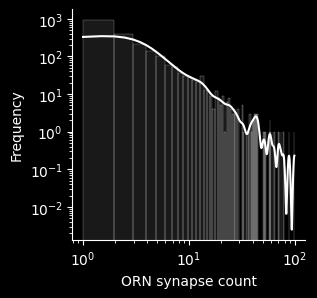

In [16]:
# get orn synapse count distribution
synapse_counts = [data[data['root_id']==r]['ORN_synapse_count'].values[0] for r in data['root_id'].unique()]
# plot the distribution
plt.figure(figsize=(3,3))
sns.histplot(synapse_counts, bins=100, kde=True, color='white', alpha=0.1)
plt.xlabel('ORN synapse count')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(os.path.join(figure_folder, 'ORN_synapse_count_distribution.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [17]:
data.iloc[0]

ORN_type                                                                                             ORN_D
receptor_guesses                                                                                     Or69a
antenna_side                                                                                          left
root_id                                                                                 720575940619891041
neurotransmitter                                                                                   unknown
neurotransmitter_confidence                                                                            0.0
ORN_synapse_count                                                                                        2
downstream_cell_types                                    ORN_D,lLN2F_b,lLN2T_b,ORN_D,il3LN6,ORN_D,lLN10...
downstream_cell_type_syn_counts                          3,2,4,2,20,1,1,1,6,18,4,2,2,1,4,4,5,3,3,4,4,4,...
downstream_cell_types_side           

In [18]:
unique_ORNs = data.groupby('root_id').agg({
    'ORN_type': 'first',
    'antenna_side': 'first',
    'neurotransmitter': 'first',
    'neurotransmitter_confidence': 'first',
    'ORN_synapse_count': 'first',
    'receptor_guesses': 'first',
    'downstream_cell_types_side': 'first',
    'downstream_cell_type_syn_counts': 'first',
}).reset_index()

# calculate the number of downstream neurons on ipsi and contra sides
unique_ORNs['downstream_partners_ipsi'] = unique_ORNs.apply(lambda x: len([s for s in x['downstream_cell_types_side'].split(',') if s == 'ipsilateral']), axis=1)
unique_ORNs['downstream_partners_contra'] = unique_ORNs.apply(lambda x: len([s for s in x['downstream_cell_types_side'].split(',') if s == 'contralateral']), axis=1)
# calculate the total number of downstream neurons
unique_ORNs['downstream_partners_total'] = unique_ORNs['downstream_partners_ipsi'] + unique_ORNs['downstream_partners_contra']

# calculate the number of synapses on ipsi and contra sides
unique_ORNs['downstream_synapses_ipsi'] = unique_ORNs.apply(lambda x: np.sum([int(s) for s,d in zip(x['downstream_cell_type_syn_counts'].split(','), x['downstream_cell_types_side'].split(',')) if d == 'ipsilateral']), axis=1)
unique_ORNs['downstream_synapses_contra'] = unique_ORNs.apply(lambda x: np.sum([int(s) for s,d in zip(x['downstream_cell_type_syn_counts'].split(','), x['downstream_cell_types_side'].split(',')) if d == 'contralateral']), axis=1)
# calculate the total number of synapses
unique_ORNs['downstream_synapses_total'] = unique_ORNs['downstream_synapses_ipsi'] + unique_ORNs['downstream_synapses_contra']

# calculate partner asymmetry
unique_ORNs['downstream_partner_asymmetry'] = (unique_ORNs['downstream_partners_ipsi'] - unique_ORNs['downstream_partners_contra'])/unique_ORNs['downstream_partners_total']
# calculate synapse asymmetry
unique_ORNs['downstream_synapse_asymmetry'] = (unique_ORNs['downstream_synapses_ipsi'] - unique_ORNs['downstream_synapses_contra'])/unique_ORNs['downstream_synapses_total']

In [19]:
lateralization_measure = 'downstream_partner_asymmetry' # which measure to use for lateralization
al_lateralization_indices = {}
al_lateralization_indices_L = {}
al_lateralization_indices_R = {}
for orn_type in np.unique(unique_ORNs['ORN_type']):
    al_lateralization_indices[orn_type] = unique_ORNs[unique_ORNs['ORN_type']==orn_type][lateralization_measure].values
    al_lateralization_indices_L[orn_type] = unique_ORNs[(unique_ORNs['ORN_type']==orn_type) & (unique_ORNs['antenna_side']=='left')][lateralization_measure].values
    al_lateralization_indices_R[orn_type] = unique_ORNs[(unique_ORNs['ORN_type']==orn_type) & (unique_ORNs['antenna_side']=='right')][lateralization_measure].values

# sort by mean lateralization index
median_al_lateralization_indices = {k:np.median(v) for k,v in al_lateralization_indices.items()}
sorted_keys = sorted(median_al_lateralization_indices, key=median_al_lateralization_indices.get, reverse=True)
# get receptor labels
sorted_receptor_labels = {}
for k in sorted_keys:
    labels = unique_ORNs[unique_ORNs['ORN_type']==k]['receptor_guesses'].values.tolist()
    labels = [l.split(',') for l in labels]
    labels = [item for sublist in labels for item in sublist]
    # most common label
    labels = np.unique(labels, return_counts=True)
    sorted_receptor_labels[k] = labels[0][np.argmax(labels[1])]

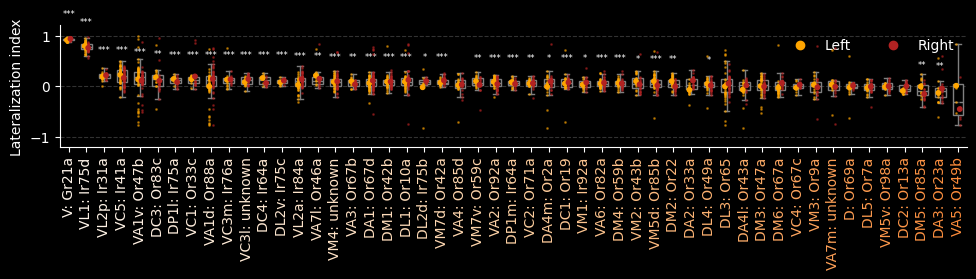

In [20]:
# plot the lateralization indices in order
plt.figure(figsize=(10,3))

# find the ones that the significantly different from 0 (using wilcoxon one sample test)
ORN_significance = {}
for k in sorted_keys:
    t,p = wilcoxon(al_lateralization_indices[k])
    ORN_significance[k] = p

# for each ORN type
for n,k in enumerate(sorted_keys):
    plt.boxplot(al_lateralization_indices[k], positions=[n], widths=0.6, showfliers=False, patch_artist=True, boxprops=dict(facecolor='black', color='gray'), medianprops=dict(color='gray'), whiskerprops=dict(color='gray'), capprops=dict(color='gray'))
    # add the significance stars
    plt.text(n, np.median(al_lateralization_indices[k])+0.5, p_value_to_stars(ORN_significance[k]), ha='center', va='center', color='white', fontsize=6)
# plot the left and right lateralization indices
for n,k in enumerate(sorted_keys):
    plt.scatter([n-0.1]*len(al_lateralization_indices_L[k]), al_lateralization_indices_L[k], color='orange', alpha=0.5, s=1, zorder=10)
    plt.scatter([n+0.1]*len(al_lateralization_indices_R[k]), al_lateralization_indices_R[k], color='firebrick', alpha=0.5, s=1, zorder=10)
    # add a line connecting the means
    plt.scatter([n-0.1,n+0.1], [np.mean(al_lateralization_indices_L[k]), np.mean(al_lateralization_indices_R[k])], c=['orange','firebrick'], s=10, zorder=10)
    plt.plot([n-0.1,n+0.1], [np.mean(al_lateralization_indices_L[k]), np.mean(al_lateralization_indices_R[k])], color='black', alpha=0.5, zorder=5)
tick_labels = [k.replace('ORN_','')+': '+sorted_receptor_labels[k] for k in sorted_keys]
plt.xticks(range(len(sorted_keys)), tick_labels, rotation=90)
# color x tick labels from orangered to white
colors = plt.cm.Oranges(np.linspace(0, 0.5, len(sorted_keys)))
for i,c in enumerate(colors):
    plt.gca().get_xticklabels()[i].set_color(c)
plt.ylim(-1.2,1.2)
plt.ylabel('Lateralization index')
plt.scatter([],[],color='orange',label='Left')
plt.scatter([],[],color='firebrick',label='Right')
plt.legend( loc='upper right', ncol=2, frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'AL_input_lateralization_index.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# create a figure subfolder for each ORN type
for k in sorted_keys:
    os.makedirs(os.path.join(figure_folder, k), exist_ok=True)

Plot neurons:   0%|          | 0/34 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/33 [00:00<?, ?it/s]

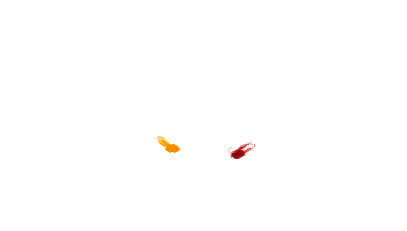

Plot neurons:   0%|          | 0/39 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/39 [00:00<?, ?it/s]

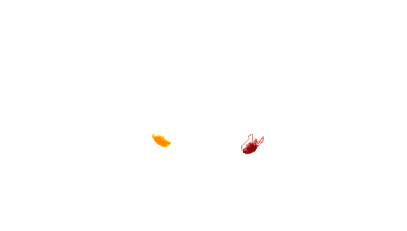

Plot neurons:   0%|          | 0/14 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/13 [00:00<?, ?it/s]

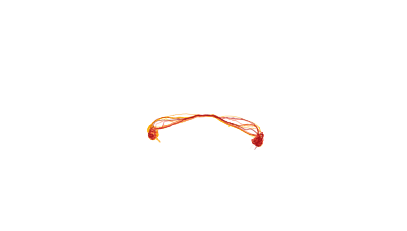

Plot neurons:   0%|          | 0/40 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/40 [00:00<?, ?it/s]

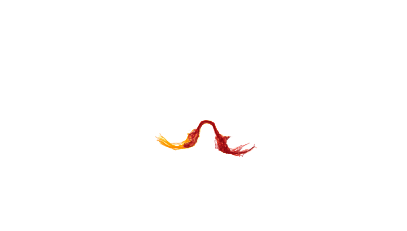

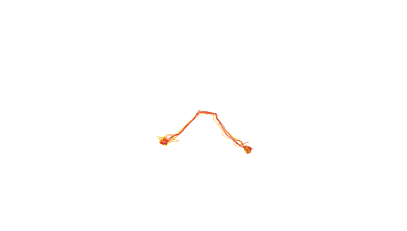

Plot neurons:   0%|          | 0/14 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/16 [00:00<?, ?it/s]

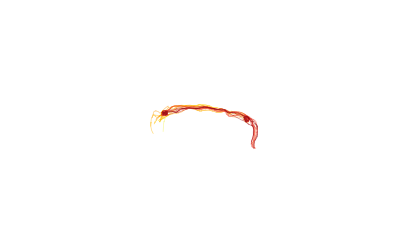

Plot neurons:   0%|          | 0/21 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/21 [00:00<?, ?it/s]

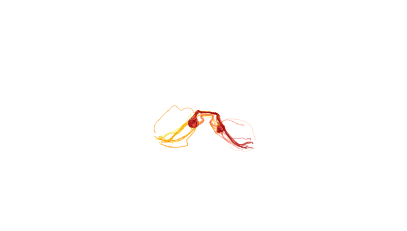

Plot neurons:   0%|          | 0/12 [00:00<?, ?it/s]

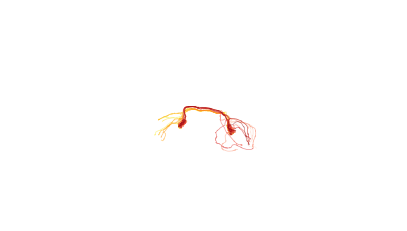

In [22]:
#  plot the orns with the most ipsi and contra lateralized inputs
n = 4

# ipsi lateralized
ipsi_lateralized = sorted_keys[:n]
# contra lateralized
contra_lateralized = sorted_keys[-n:][::-1]

# loop through ipsi and contra lateralized ORNs
for ipsi_type in ipsi_lateralized:
    # get the left and right ORNs of this type
    left_OR_subset_skeleton = [left_ORN_skeletons[i] for i in range(len(left_ORNs)) if left_ORN_types[i] == ipsi_type]
    right_OR_subset_skeleton = [right_ORN_skeletons[i] for i in range(len(right_ORNs)) if right_ORN_types[i] == ipsi_type]
    # plot the left ORNs
    fig, ax = navis.plot2d(left_OR_subset_skeleton, alpha=0.5, lw=0.5, palette='Wistia', figsize=(5,5))
    # plot the right ORNs
    _ = navis.plot2d(right_OR_subset_skeleton, ax=ax, alpha=0.5, lw=0.5, palette='Reds')
    _ = navis.plot2d(flybrains.FLYWIRE, ax=ax, color='white', lw=0.5, alpha=0.1)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    ax.azim = ax.elev = -90
    ax.set_axis_off()
    ax.grid(False)
    ax.invert_yaxis()
    plt.title( ipsi_type.split('_')[-1] + ' Glomerulus (' + sorted_receptor_labels[ipsi_type] + ')')
    plt.savefig(os.path.join(figure_folder, ipsi_type+'/lateralized_ORNs.pdf'), dpi=300, bbox_inches='tight')
    plt.show()

for contra_type in contra_lateralized:
    # get the left and right ORNs of this type
    left_OR_subset_skeleton = [left_ORN_skeletons[i] for i in range(len(left_ORNs)) if left_ORN_types[i] == contra_type]
    right_OR_subset_skeleton = [right_ORN_skeletons[i] for i in range(len(right_ORNs)) if right_ORN_types[i] == contra_type]
    # plot the left ORNs
    fig, ax = navis.plot2d(left_OR_subset_skeleton, alpha=0.5, lw=0.5, palette='Wistia', figsize=(5,5))
    # plot the right ORNs
    _ = navis.plot2d(right_OR_subset_skeleton, ax=ax, alpha=0.5, lw=0.5, palette='Reds')
    _ = navis.plot2d(flybrains.FLYWIRE, ax=ax, color='white', lw=0.5, alpha=0.1)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    ax.azim = ax.elev = -90
    ax.set_axis_off()
    ax.grid(False)
    ax.invert_yaxis()
    plt.title( contra_type.split('_')[-1] + ' Glomerulus (' + sorted_receptor_labels[contra_type] + ')')
    plt.savefig(os.path.join(figure_folder, contra_type+'/lateralized_ORNs.pdf'), dpi=300, bbox_inches='tight')
    plt.show()



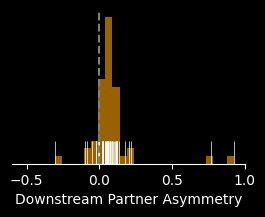

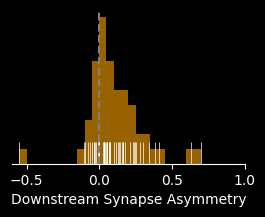

In [23]:
lateralization_measure = 'downstream_partner_asymmetry' # which measure to use for lateralization
al_lateralization_indices = {}
al_lateralization_indices_L = {}
al_lateralization_indices_R = {}
for orn_type in np.unique(unique_ORNs['ORN_type']):
    al_lateralization_indices[orn_type] = unique_ORNs[unique_ORNs['ORN_type']==orn_type][lateralization_measure].values

# sort by mean lateralization index
median_al_lateralization_indices = {k:np.median(v) for k,v in al_lateralization_indices.items()}

# plot the distribution of the two lateralization indices
plt.figure(figsize=(3,2))
plt.hist(list(median_al_lateralization_indices.values()), bins=25, color='orange', alpha=0.6)
# draw a notch at each value
for n,k in enumerate(median_al_lateralization_indices.keys()):
    plt.vlines(median_al_lateralization_indices[k], 0, 3, color='white', alpha=1, lw=0.5)
plt.axvline(0, color='gray', linestyle='--')
plt.xlim(-0.6,1)
plt.xlabel('Downstream Partner Asymmetry')
ax = plt.gca()
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(figure_folder, 'downstream_partner_asymmetry_distribution.pdf'), dpi=300, bbox_inches='tight')
plt.show()

# plot the distribution of the two lateralization indices

lateralization_measure = 'downstream_synapse_asymmetry' # which measure to use for lateralization
al_lateralization_indices = {}
al_lateralization_indices_L = {}
al_lateralization_indices_R = {}
for orn_type in np.unique(unique_ORNs['ORN_type']):
    al_lateralization_indices[orn_type] = unique_ORNs[unique_ORNs['ORN_type']==orn_type][lateralization_measure].values

# sort by mean lateralization index
median_al_lateralization_indices = {k:np.median(v) for k,v in al_lateralization_indices.items()}

# plot the distribution of the two lateralization indices
plt.figure(figsize=(3,2))
plt.hist(list(median_al_lateralization_indices.values()), bins=25, color='orange', alpha=0.6)
for n,k in enumerate(median_al_lateralization_indices.keys()):
    plt.vlines(median_al_lateralization_indices[k], 0, 1.5, color='white', alpha=1, lw=0.5)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Downstream Synapse Asymmetry')
plt.xlim(-0.6,1)
ax = plt.gca()
ax.yaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig(os.path.join(figure_folder, 'downstream_synapse_asymmetry_distribution.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [24]:
lateralization_measure = 'downstream_partner_asymmetry' # which measure to use for lateralization
al_lateralization_indices = {}
al_lateralization_indices_L = {}
al_lateralization_indices_R = {}
for orn_type in np.unique(unique_ORNs['ORN_type']):
    al_lateralization_indices[orn_type] = unique_ORNs[unique_ORNs['ORN_type']==orn_type][lateralization_measure].values
    al_lateralization_indices_L[orn_type] = unique_ORNs[(unique_ORNs['ORN_type']==orn_type) & (unique_ORNs['antenna_side']=='left')][lateralization_measure].values
    al_lateralization_indices_R[orn_type] = unique_ORNs[(unique_ORNs['ORN_type']==orn_type) & (unique_ORNs['antenna_side']=='right')][lateralization_measure].values

# sort by mean lateralization index
median_al_lateralization_indices = {k:np.median(v) for k,v in al_lateralization_indices.items()}
sorted_keys = sorted(median_al_lateralization_indices, key=median_al_lateralization_indices.get, reverse=True)
# get receptor labels
sorted_receptor_labels = {}
for k in sorted_keys:
    labels = unique_ORNs[unique_ORNs['ORN_type']==k]['receptor_guesses'].values.tolist()
    labels = [l.split(',') for l in labels]
    labels = [item for sublist in labels for item in sublist]
    # most common label
    labels = np.unique(labels, return_counts=True)
    sorted_receptor_labels[k] = labels[0][np.argmax(labels[1])]

In [25]:
data = load_and_clean_data(verbose=True)
all_classes = ['ALLN', 'uniglomerular ALPN', 'multiglomerular ALPN']

Fraction of uncertain neurotransmitters: 0.7155232094757724
Fraction of uncertain downstream neurotransmitters: 0.767125678482294
Fraction of unknown classes: 0.010989522429911979


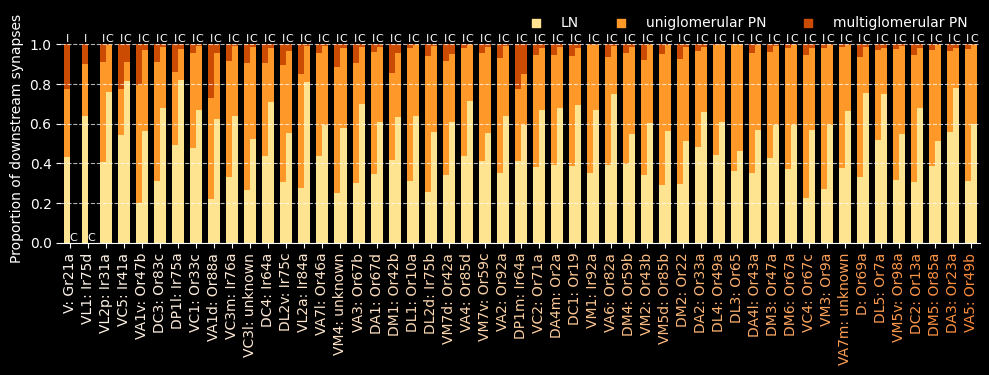

In [26]:
index = 0
plt.figure(figsize=(10,4))
# get 10 random colors
colors = sns.color_palette('YlOrBr', n_colors=len(all_classes))
contralateral_LN_count = {}
ipsilateral_LN_count = {}
contralateral_LN_fraction = {}
ipsilateral_LN_fraction = {}
for orn_type in sorted_keys:
    for orientation in ['ipsilateral', 'contralateral']:
        peak = 0
        # get the classes
        classes = data[(data['ORN_type']==orn_type) & (data['downstream_neuron_orientation']==orientation)]['downstream_neuron_class']
        classes = classes.map({c:i for i,c in enumerate(all_classes)}) # map to the unique classes
        # get synapse counts
        syn_count = data[(data['ORN_type']==orn_type) & (data['downstream_neuron_orientation']==orientation)]['downstream_neuron_input_synapse_count']
        # multiple by the synapse count
        classes = classes.repeat(syn_count)
        class_distribution = classes.value_counts().sort_index() # count the classes
        if orientation == 'contralateral' and 0 in class_distribution:
            contralateral_LN_count[orn_type] = class_distribution[0]
        if orientation == 'ipsilateral' and 0 in class_distribution:
            ipsilateral_LN_count[orn_type] = class_distribution[0]
        # normalize
        class_distribution = class_distribution/class_distribution.sum()
        # # save the fraction of LN synapses on the contralateral side
        if orientation == 'contralateral' and 0 in class_distribution:
            contralateral_LN_fraction[orn_type] = class_distribution[0]
        if orientation == 'ipsilateral' and 0 in class_distribution:
            ipsilateral_LN_fraction[orn_type] = class_distribution[0]
        for cls_id in range(len(all_classes)):
            if cls_id in class_distribution:
                peak+=class_distribution[cls_id]
                plt.bar(index, peak, color=colors[cls_id], zorder=-cls_id, width=1)
        plt.text(index, peak, "I" if orientation == 'ipsilateral' else "C", ha='center', va='bottom', fontsize=8)
        index+=1
    index+=1
# add the legend
for cls_id,cls_name in enumerate(all_classes):
    plt.scatter([],[],color=colors[cls_id],label=cls_name.replace('AL',''),marker='s')
plt.legend(loc='upper right', ncol=3, frameon=False, bbox_to_anchor=(1,1.15))
# add the labels
plt.xticks(np.arange(len(sorted_keys))*3+0.5, [k.replace('ORN_','')+': '+sorted_receptor_labels[k] for k in sorted_keys], rotation=90)
# color x tick labels from orangered to white
colors = plt.cm.Oranges(np.linspace(0, 0.5, len(sorted_keys)))
for i,c in enumerate(colors):
    plt.gca().get_xticklabels()[i].set_color(c)

plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.ylim(0,1.1)
plt.xlim(-1,index-1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.ylabel('Proportion of downstream synapses')
# plt.title('I = ipsilateral | C = contralateral')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'downstream_synapse_distribution.pdf'), dpi=300, bbox_inches='tight')
plt.show()

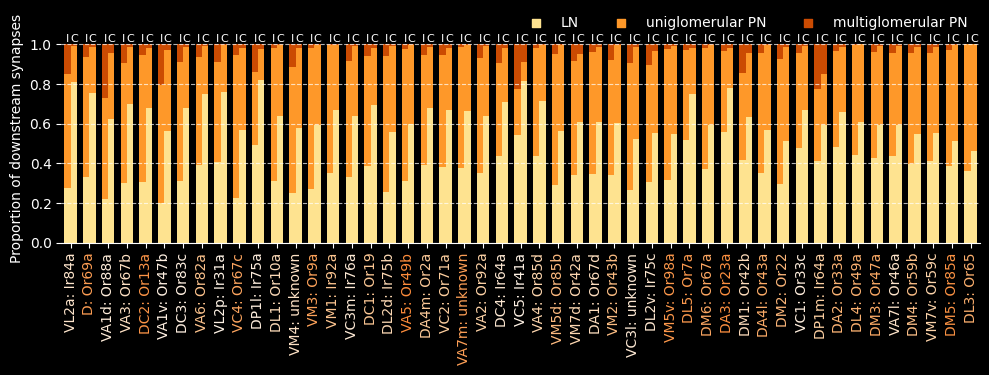

In [27]:
# resort the keys by the contralaeral fraction
resorted_keys = sorted(contralateral_LN_fraction, key=lambda x: contralateral_LN_fraction[x]-ipsilateral_LN_fraction[x], reverse=True)

index = 0
plt.figure(figsize=(10,4))
# get 10 random colors
colors = sns.color_palette('YlOrBr', n_colors=len(all_classes))
for orn_type in resorted_keys:
    for orientation in ['ipsilateral', 'contralateral']:
        peak = 0
        # get the classes
        classes = data[(data['ORN_type']==orn_type) & (data['downstream_neuron_orientation']==orientation)]['downstream_neuron_class']
        classes = classes.map({c:i for i,c in enumerate(all_classes)}) # map to the unique classes
        # get synapse counts
        syn_count = data[(data['ORN_type']==orn_type) & (data['downstream_neuron_orientation']==orientation)]['downstream_neuron_input_synapse_count']
        # multiple by the synapse count
        classes = classes.repeat(syn_count)
        class_distribution = classes.value_counts().sort_index() # count the classes
        # normalize
        class_distribution = class_distribution/class_distribution.sum()
        for cls_id in range(len(all_classes)):
            if cls_id in class_distribution:
                peak+=class_distribution[cls_id]
                plt.bar(index, peak, color=colors[cls_id], zorder=-cls_id, width=1)
        plt.text(index, peak, "I" if orientation == 'ipsilateral' else "C", ha='center', va='bottom', fontsize=8)
        index+=1
    index+=1
# add the legend
for cls_id,cls_name in enumerate(all_classes):
    plt.scatter([],[],color=colors[cls_id],label=cls_name.replace('AL',''),marker='s')
plt.legend(loc='upper right', ncol=3, frameon=False, bbox_to_anchor=(1,1.15))
# add the labels
plt.xticks(np.arange(len(resorted_keys))*3+0.5, [k.replace('ORN_','')+': '+sorted_receptor_labels[k] for k in resorted_keys], rotation=90)
# color x tick labels from orangered to white in the ORIGINAl order
colors = plt.cm.Oranges(np.linspace(0, 0.5, len(sorted_keys)))
for i in range(len(resorted_keys)):
    # get original index
    original_index = list(sorted_keys).index(resorted_keys[i])
    plt.gca().get_xticklabels()[i].set_color(colors[original_index])

plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.ylim(0,1.1)
plt.xlim(-1,index-1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.ylabel('Proportion of downstream synapses')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'downstream_synapse_distribution_sorted.pdf'), dpi=300, bbox_inches='tight')
plt.show()

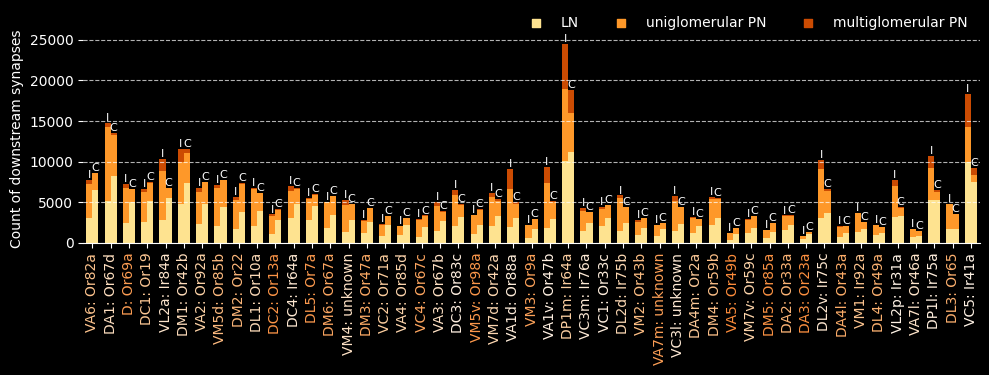

In [28]:
# resort the keys by the contralaeral fraction
resorted_keys = sorted(contralateral_LN_fraction, key=lambda x: contralateral_LN_count[x]-ipsilateral_LN_count[x], reverse=True)

index = 0
plt.figure(figsize=(10,4))
# get 10 random colors
colors = sns.color_palette('YlOrBr', n_colors=len(all_classes))
for orn_type in resorted_keys:
    for orientation in ['ipsilateral', 'contralateral']:
        peak = 0
        # get the classes
        classes = data[(data['ORN_type']==orn_type) & (data['downstream_neuron_orientation']==orientation)]['downstream_neuron_class']
        classes = classes.map({c:i for i,c in enumerate(all_classes)}) # map to the unique classes
        # get synapse counts
        syn_count = data[(data['ORN_type']==orn_type) & (data['downstream_neuron_orientation']==orientation)]['downstream_neuron_input_synapse_count']
        # multiple by the synapse count
        classes = classes.repeat(syn_count)
        class_distribution = classes.value_counts().sort_index() # count the classes
        for cls_id in range(len(all_classes)):
            if cls_id in class_distribution:
                peak+=class_distribution[cls_id]
                plt.bar(index, peak, color=colors[cls_id], zorder=-cls_id, width=1)
        plt.text(index, peak, "I" if orientation == 'ipsilateral' else "C", ha='center', va='bottom', fontsize=8)
        index+=1
    index+=1
# add the legend
for cls_id,cls_name in enumerate(all_classes):
    plt.scatter([],[],color=colors[cls_id],label=cls_name.replace('AL',''),marker='s')
plt.legend(loc='upper right', ncol=3, frameon=False, bbox_to_anchor=(1,1.15))
# add the labels
plt.xticks(np.arange(len(resorted_keys))*3+0.5, [k.replace('ORN_','')+': '+sorted_receptor_labels[k] for k in resorted_keys], rotation=90)
# color x tick labels from orangered to white in the ORIGINAl order
colors = plt.cm.Oranges(np.linspace(0, 0.5, len(sorted_keys)))
for i in range(len(resorted_keys)):
    # get original index
    original_index = list(sorted_keys).index(resorted_keys[i])
    plt.gca().get_xticklabels()[i].set_color(colors[original_index])

plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.ylim(0,1.1)
plt.xlim(-1,index-1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.ylabel('Count of downstream synapses')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'downstream_synapse_distribution_sorted.pdf'), dpi=300, bbox_inches='tight')
plt.show()

Fraction of uncertain neurotransmitters: 0.7155232094757724
Fraction of uncertain downstream neurotransmitters: 0.767125678482294
Fraction of unknown classes: 0.010989522429911979


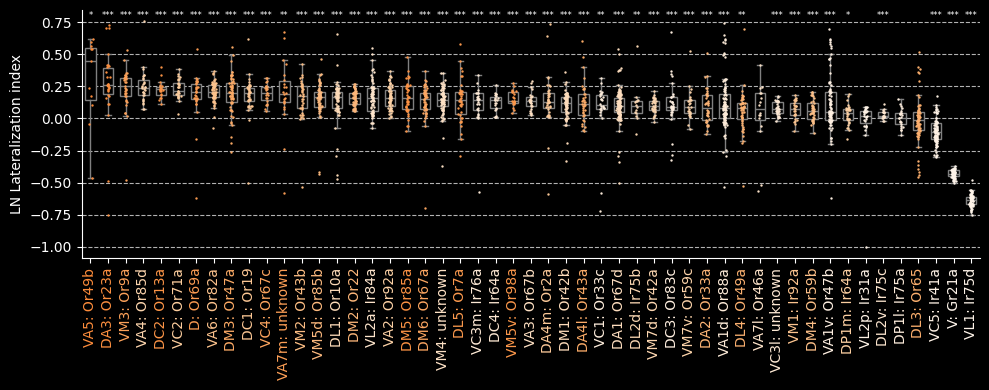

In [29]:
# get the difference in number of LN outputs between ipsilateral and contralateral
data = load_and_clean_data(verbose=True)

LN_lateralization = {}
for orn_type in sorted_keys:
    all_ors = data[(data['ORN_type']==orn_type)]
    lateralizations = []
    # loop trough all unique ORNs
    for root_id in np.unique(all_ors['root_id']):
        ipsilateral = all_ors[(all_ors['root_id']==root_id) & (all_ors['downstream_neuron_orientation']=='ipsilateral') & (all_ors['downstream_neuron_class'] == 'ALLN')]
        all_ipsilateral = all_ors[(all_ors['root_id']==root_id) & (all_ors['downstream_neuron_orientation']=='ipsilateral')]
        contralateral = all_ors[(all_ors['root_id']==root_id) & (all_ors['downstream_neuron_orientation']=='contralateral') & (all_ors['downstream_neuron_class'] == 'ALLN')]
        all_contralateral = all_ors[(all_ors['root_id']==root_id) & (all_ors['downstream_neuron_orientation']=='contralateral')]
        ipsilateral_count = ipsilateral['downstream_neuron_input_synapse_count'].sum()
        contralateral_count = contralateral['downstream_neuron_input_synapse_count'].sum()
        all_counts = all_ipsilateral['downstream_neuron_input_synapse_count'].sum() + all_contralateral['downstream_neuron_input_synapse_count'].sum()
        lateralizations.append((contralateral_count-ipsilateral_count)/all_counts)
    LN_lateralization[orn_type] = np.array(lateralizations)

# sort by mean lateralization index
mean_al_lateralization_indices = {k:np.nanmedian(v) for k,v in LN_lateralization.items()}
sorted_keys_ln = sorted(mean_al_lateralization_indices, key=mean_al_lateralization_indices.get, reverse=True)

# calculate the significance of the lateralization index
LN_significance = {}
for k in sorted_keys:
    t,p = wilcoxon(LN_lateralization[k])
    LN_significance[k] = p
    
# plot the lateralization indices in sorted order
plt.figure(figsize=(10,4))

colors = plt.cm.Oranges(np.linspace(0, 0.5, len(sorted_keys)))
# for each ORN type show the distribution of LN lateralization
for n,k in enumerate(sorted_keys_ln):
    plt.boxplot(LN_lateralization[k], positions=[n], widths=0.6, showfliers=False, patch_artist=True, boxprops=dict(facecolor='black', color='gray'), medianprops=dict(color='gray'), whiskerprops=dict(color='gray'), capprops=dict(color='gray'))
    # add the significance stars
    plt.text(n,0.8, p_value_to_stars(LN_significance[k]), ha='center', va='center', color='white', fontsize=6)

    # color scatter plot by original color
    original_index = list(sorted_keys).index(k)
    plt.scatter(np.random.normal(n, 0.05, len(LN_lateralization[k])), LN_lateralization[k], color=colors[original_index], alpha=1, s=0.5, zorder=5)

plt.xticks(range(len(sorted_keys_ln)), [x.replace('ORN_','')+': '+sorted_receptor_labels[x] for x in sorted_keys_ln], rotation=90)
# color x tick labels from orangered to white in the ORIGINAl order
for i in range(len(sorted_keys_ln)):
    # get original index
    original_index = list(sorted_keys).index(sorted_keys_ln[i])
    plt.gca().get_xticklabels()[i].set_color(colors[original_index])
plt.ylabel('LN Lateralization index')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'LN_input_lateralization_index.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [30]:
neurotransmitter_confidence_threshold = 0.50
data = load_and_clean_data(neurotransmitter_confidence_threshold, verbose=True)
# remove neurons that are not classified as LN or PN
data = data[data['downstream_neuron_class'].str.contains('ALLN|ALPN')]
# map the classes to only LN or PN
data['downstream_neuron_class'] = data['downstream_neuron_class'].map({'ALLN':'LN', 'uniglomerular ALPN':'PN', 'multiglomerular ALPN':'PN'})
all_classes = ['PN', 'LN']
all_neurotransmitters = ['ACH', 'GABA', 'GLUT', 'SER', 'unknown']

Fraction of uncertain neurotransmitters: 0.2901955308887609
Fraction of uncertain downstream neurotransmitters: 0.5219935889604459
Fraction of unknown classes: 0.010989522429911979


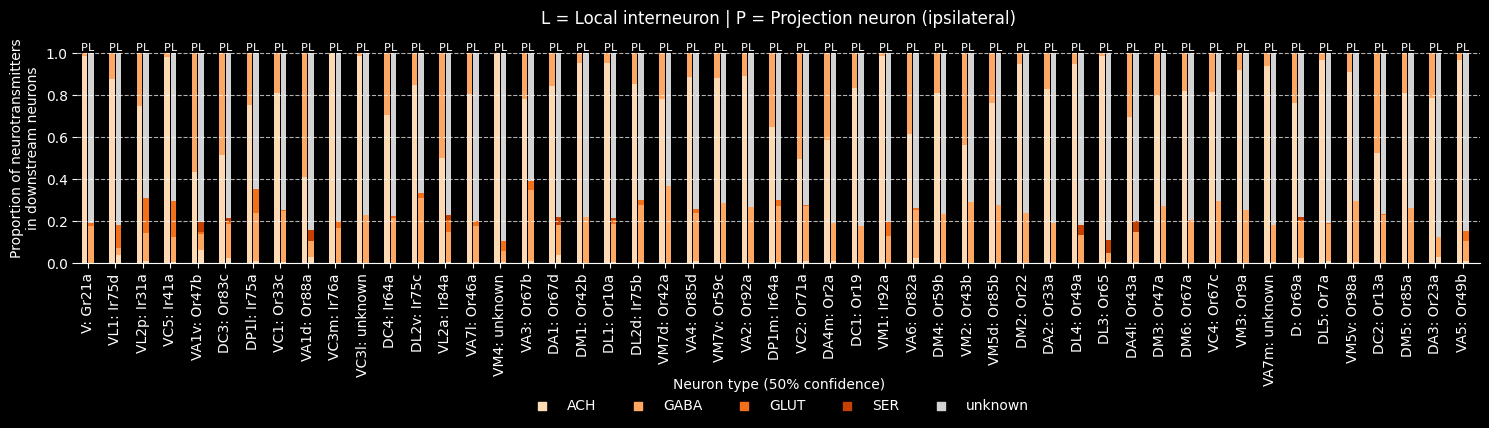

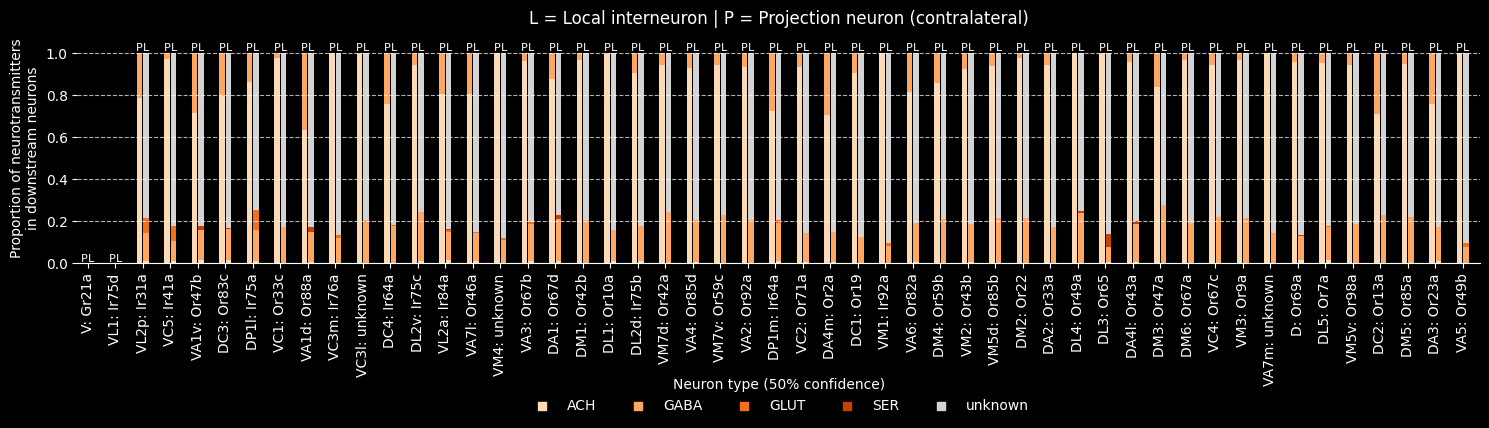

In [31]:
for lateralization in ['ipsilateral', 'contralateral']:
    index = 0
    plt.figure(figsize=(15,6))
    # get 10 random colors
    colors = sns.color_palette('Oranges', n_colors=len(all_neurotransmitters)-1) + ['lightgray']
    for orn_type in sorted_keys:
        for class_name in all_classes:
            peak = 0
            # get the neurotransmitters
            neurotransmitters = data[(data['ORN_type']==orn_type) & (data['downstream_neuron_class']==class_name) & (data['downstream_neuron_orientation']==lateralization)]
            neurotransmitters = neurotransmitters['downstream_neuron_neurotransmitter']
            neurotransmitters = neurotransmitters.map({c:i for i,c in enumerate(all_neurotransmitters)}) # map to the unique neurotransmitters
            neurotransmitter_distribution = neurotransmitters.value_counts().sort_index() # count the neurotransmitters
            # normalize
            neurotransmitter_distribution = neurotransmitter_distribution/neurotransmitter_distribution.sum()
            for cls_id in range(len(all_neurotransmitters)):
                if cls_id in neurotransmitter_distribution:
                    peak+=neurotransmitter_distribution[cls_id]
                    plt.bar(index, peak, color=colors[cls_id], zorder=-cls_id)
            plt.text(index, peak, "L" if class_name == 'LN' else "P", ha='center', va='bottom', fontsize=8)
            index+=1
        index+=2
    # add the labels
    plt.xticks(np.arange(len(sorted_keys))*4+0.5, [k.replace('ORN_','')+': '+sorted_receptor_labels[k] for k in sorted_keys], rotation=90)
    # add the legend
    for cls_id,cls in enumerate(all_neurotransmitters):
        plt.scatter([],[],color=colors[cls_id],label=cls,marker='s')
    plt.legend(bbox_to_anchor=(0.5, -0.7), loc='lower center', ncol=5, frameon=False, title='Neuron type ({}% confidence)'.format(int(neurotransmitter_confidence_threshold*100)))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0,1.1)
    plt.xlim(-1,index-1)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.ylabel('Proportion of neurotransmitters\nin downstream neurons')
    plt.title('L = Local interneuron | P = Projection neuron ({})'.format(lateralization))
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, 'downstream_neurotransmitter_distribution_{}.pdf'.format(lateralization)), dpi=300, bbox_inches='tight')
    plt.show()

In [32]:
data = load_and_clean_data()
# remove neurons that are not classified as LN or PN
data = data[data['downstream_neuron_class'].str.contains('ALLN|ALPN')]
# map the classes to only LN or PN
data['downstream_neuron_class'] = data['downstream_neuron_class'].map({'ALLN':'LN', 'uniglomerular ALPN':'PN', 'multiglomerular ALPN':'PN'})
all_classes = ['PN', 'LN']


/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_79930/3443923345.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


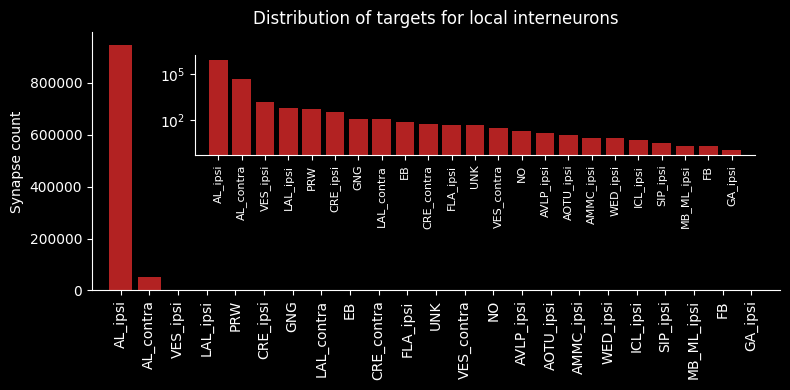

/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_79930/3443923345.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


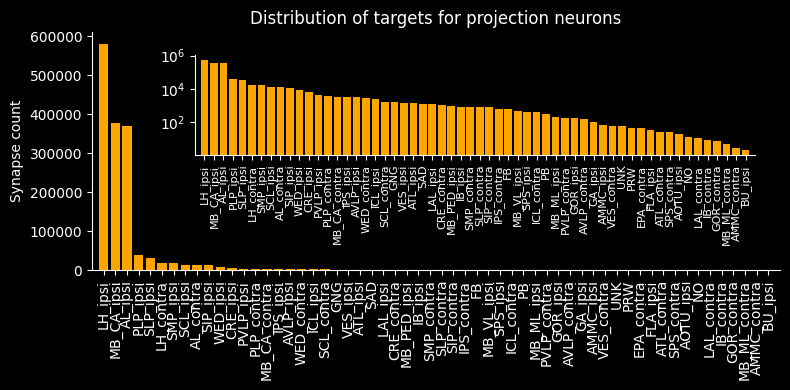

In [33]:

LN_data = data[data['downstream_neuron_class']=='LN'].groupby('downstream_neuron_root_id').first().reset_index()
PN_data = data[data['downstream_neuron_class']=='PN'].groupby('downstream_neuron_root_id').first().reset_index()

LN_targets = [i.split(",") for i in LN_data['downstream_neuron_downstream_targets'].values]
LN_target_synapse_counts = [i.replace('[','').replace(']','').split(' ') for i in LN_data['downstream_neuron_downstream_synapse_count'].values]

all_LN_targets = [item for sublist in LN_targets for item in sublist]
all_LN_target_synapse_counts = [item for sublist in LN_target_synapse_counts for item in sublist if len(item)>0]
all_LN_targets_regions = np.unique(all_LN_targets)
LN_counts = np.zeros(len(all_LN_targets_regions), dtype=int)
for i,r in enumerate(all_LN_targets_regions):
    LN_counts[i] = np.sum([int(c) for c,t in zip(all_LN_target_synapse_counts, all_LN_targets) if r in t])
# sort by count
sorted_LN_indices = np.argsort(LN_counts)[::-1]
all_LN_targets_regions = all_LN_targets_regions[sorted_LN_indices]
LN_counts = LN_counts[sorted_LN_indices]

# plot the distribution
fig = plt.figure(figsize=(8,4))
plt.bar(range(len(all_LN_targets_regions)), LN_counts, color='firebrick')
plt.xticks(range(len(all_LN_targets_regions)), all_LN_targets_regions, rotation=90)
plt.ylabel('Synapse count')
plt.title('Distribution of targets for local interneurons')
plt.xlim(-1,len(all_LN_targets_regions))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# add a log scale plot in an inset
# create an inset
axins = fig.add_axes([0.25, 0.6, 0.7, 0.25])
axins.bar(range(len(all_LN_targets_regions)), LN_counts, color='firebrick')
axins.set_yscale('log')
axins.set_xticks(range(len(all_LN_targets_regions)))
axins.set_xticklabels(all_LN_targets_regions, rotation=90, fontsize=8)
axins.set_xlim(-1,len(all_LN_targets_regions))
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'ALL_LN_downstream_neuropils.pdf'), dpi=300, bbox_inches='tight')
plt.show()



# keep only the top 5 regions
top_LN_targets_regions = all_LN_targets_regions[:5]
# add other to the list
top_LN_targets_regions = np.append(top_LN_targets_regions, 'other')

PN_targets = [i.split(",") for i in PN_data['downstream_neuron_downstream_targets'].values]
PN_target_synapse_counts = [i.replace('[','').replace(']','').split(' ') for i in PN_data['downstream_neuron_downstream_synapse_count'].values]
all_PN_targets = [item for sublist in PN_targets for item in sublist]
all_PN_target_synapse_counts = [item for sublist in PN_target_synapse_counts for item in sublist if len(item)>0]
all_PN_targets_regions = np.unique(all_PN_targets)

PN_counts = np.zeros(len(all_PN_targets_regions), dtype=int)
for i,r in enumerate(all_PN_targets_regions):
    PN_counts[i] = np.sum([int(c) for c,t in zip(all_PN_target_synapse_counts, all_PN_targets) if r in t])
# sort by count
sorted_PN_indices = np.argsort(PN_counts)[::-1]
all_PN_targets_regions = all_PN_targets_regions[sorted_PN_indices]
PN_counts = PN_counts[sorted_PN_indices]

# plot the distribution
fig = plt.figure(figsize=(8,4))
plt.bar(range(len(all_PN_targets_regions)), PN_counts, color='orange')
plt.xticks(range(len(all_PN_targets_regions)), all_PN_targets_regions, rotation=90)
plt.ylabel('Synapse count')
plt.title('Distribution of targets for projection neurons')
plt.xlim(-1,len(all_PN_targets_regions))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# add a log scale plot in an inset
# create an inset
axins = fig.add_axes([0.25, 0.6, 0.7, 0.25])
axins.bar(range(len(all_PN_targets_regions)), PN_counts, color='orange')
axins.set_yscale('log')
axins.set_xticks(range(len(all_PN_targets_regions)))
axins.set_xticklabels(all_PN_targets_regions, rotation=90, fontsize=8)
axins.set_xlim(-1,len(all_PN_targets_regions))
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, 'ALL_PN_downstream_neuropils.pdf'))
plt.show()

# keep only the top 10 regions
top_PN_targets_regions = all_PN_targets_regions[:10]
# add other to the list
top_PN_targets_regions = np.append(top_PN_targets_regions, 'other')


In [34]:
data = load_and_clean_data()
# remove neurons that are not classified as LN or PN
data = data[data['downstream_neuron_class'].str.contains('ALLN|ALPN')]
# map the classes to only LN or PN
data['downstream_neuron_class'] = data['downstream_neuron_class'].map({'ALLN':'LN', 'uniglomerular ALPN':'PN', 'multiglomerular ALPN':'PN'})
all_classes = ['PN', 'LN']


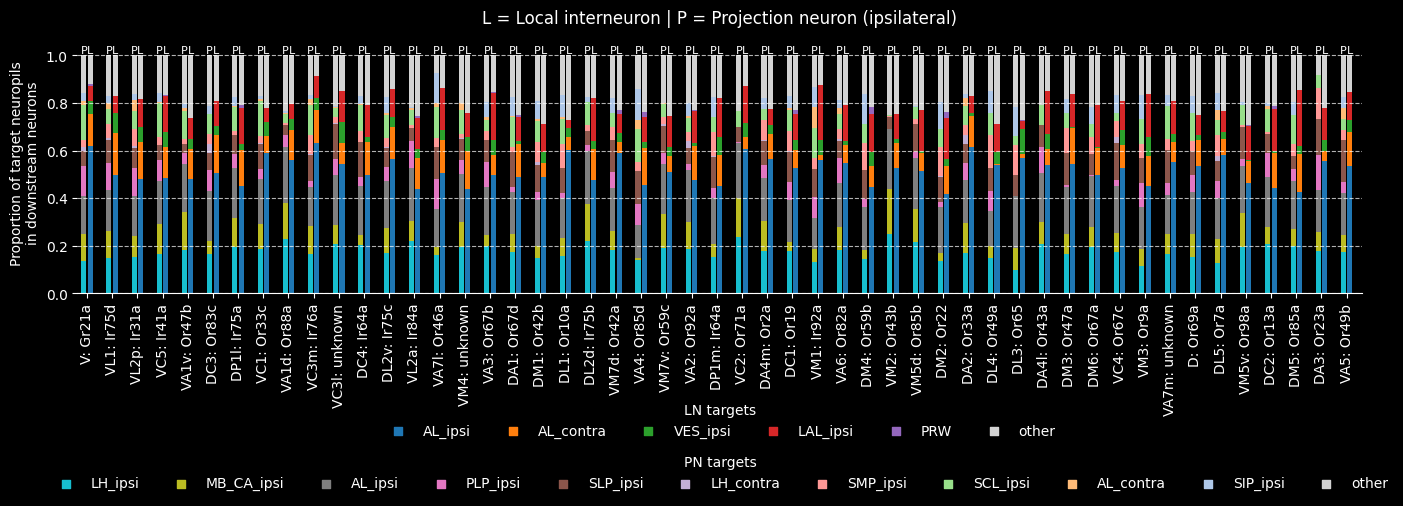

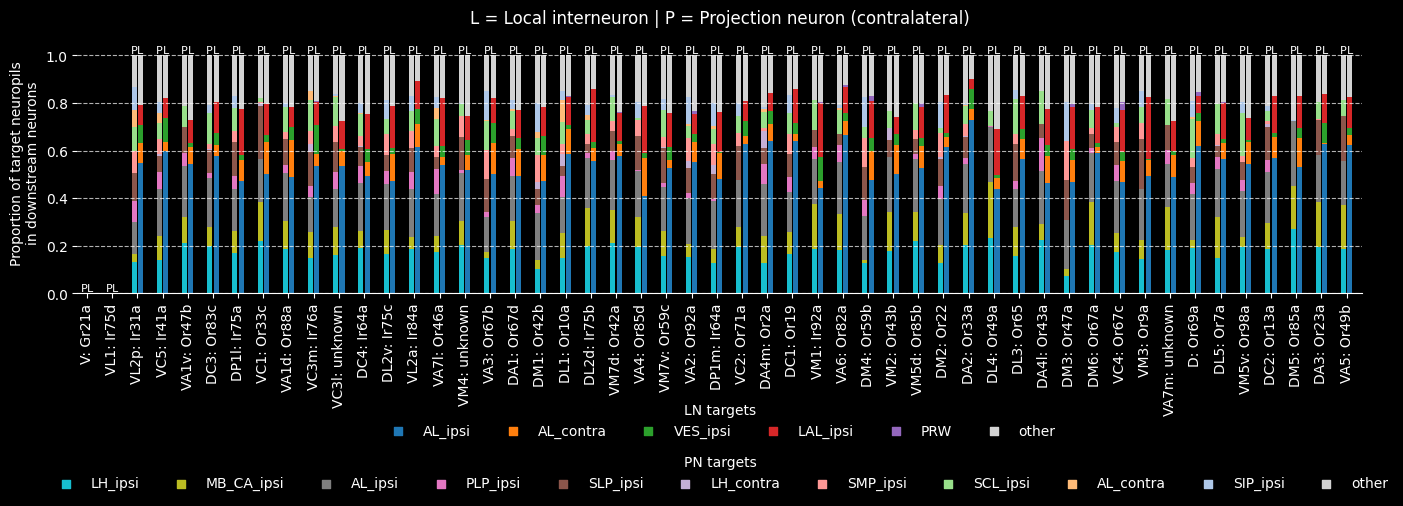

In [35]:
for lateralization in ['ipsilateral', 'contralateral']:
    index = 0
    plt.figure(figsize=(15,8))
    # get 10 random colors
    LN_colors = sns.color_palette('tab10', n_colors=len(top_LN_targets_regions)-1) + ['lightgray']
    PN_colors = sns.color_palette('tab20_r', n_colors=len(top_PN_targets_regions)-1) + ['lightgray']

    for orn_type in sorted_keys:
        LN_data = data[(data['downstream_neuron_class']=='LN') & (data['ORN_type']==orn_type) & (data['downstream_neuron_orientation']==lateralization)].groupby('downstream_neuron_root_id').first().reset_index()
        PN_data = data[(data['downstream_neuron_class']=='PN') & (data['ORN_type']==orn_type) & (data['downstream_neuron_orientation']==lateralization)].groupby('downstream_neuron_root_id').first().reset_index()
        
        peak = 0
        PN_targets = [i.split(",") for i in PN_data['downstream_neuron_downstream_targets'].values]
        PN_target_synapse_counts = [i.replace('[','').replace(']','').split(' ') for i in PN_data['downstream_neuron_downstream_synapse_count'].values]
        # set the non-top regions to other
        PN_targets = [[r if r in top_PN_targets_regions else 'other' for r in t] for t in PN_targets]
        # remove the empty
        PN_target_synapse_counts = [[r for r in t if len(r)>0] for t in PN_target_synapse_counts]
        PN_distribution = np.zeros(len(top_PN_targets_regions))
        for i,r in enumerate(top_PN_targets_regions):
            PN_distribution[i] = np.sum([int(c) for c,t in zip(all_PN_target_synapse_counts, PN_targets) if r in t])
        PN_distribution = PN_distribution / np.sum(PN_distribution) if np.sum(PN_distribution) > 0 else np.zeros(len(top_PN_targets_regions))
        for cls_id in range(len(top_PN_targets_regions)):
            peak+=PN_distribution[cls_id]
            plt.bar(index, peak, color=PN_colors[cls_id], zorder=-cls_id)
        plt.text(index, peak, "P", ha='center', va='bottom', fontsize=8)
        index+=1

        peak = 0
        LN_targets = [i.split(",") for i in LN_data['downstream_neuron_downstream_targets'].values]
        LN_target_synapse_counts = [i.replace('[','').replace(']','').split(' ') for i in LN_data['downstream_neuron_downstream_synapse_count'].values]
        # set the non-top regions to other
        LN_targets = [[r if r in top_LN_targets_regions else 'other' for r in t] for t in LN_targets]
        # remove the empty
        LN_target_synapse_counts = [[r for r in t if len(r)>0] for t in LN_target_synapse_counts]
        LN_distribution = np.zeros(len(top_LN_targets_regions))
        for i,r in enumerate(top_LN_targets_regions):
            LN_distribution[i] = np.sum([int(c) for c,t in zip(all_LN_target_synapse_counts, LN_targets) if r in t])
        LN_distribution = LN_distribution / np.sum(LN_distribution) if np.sum(LN_distribution) > 0 else LN_distribution
        for cls_id in range(len(top_LN_targets_regions)):
            peak+=LN_distribution[cls_id]
            plt.bar(index, peak, color=LN_colors[cls_id], zorder=-cls_id)
        plt.text(index, peak, "L", ha='center', va='bottom', fontsize=8)
        index+=1

        index+=2
    # add the labels
    plt.xticks(np.arange(len(sorted_keys))*4+0.5, [k.replace('ORN_','')+': '+sorted_receptor_labels[k] for k in sorted_keys], rotation=90)
    # manually add two legends
    plots = []
    for cls_id,cls_name in enumerate(top_LN_targets_regions):
        s = plt.scatter([],[],color=LN_colors[cls_id],label=cls_name,marker='s')
        plots.append(s)
    leg1 = plt.legend(handles=plots, bbox_to_anchor=(0.5, -0.6), loc='lower center', ncol=6, frameon=False, title='LN targets')
    plt.gca().add_artist(leg1)

    plots = []
    for cls_id,cls_name in enumerate(top_PN_targets_regions):
        s = plt.scatter([],[],color=PN_colors[cls_id],label=cls_name,marker='s')
        plots.append(s)
    plt.legend(handles=plots, bbox_to_anchor=(0.5, -0.8), loc='lower center', ncol=11, frameon=False, title='PN targets')


    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0,1.1)
    plt.xlim(-1,index-1)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.ylabel('Proportion of target neuropils\nin downstream neurons')
    plt.title('L = Local interneuron | P = Projection neuron ({})'.format(lateralization))
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, 'downstream_neuropil_distribution_{}.pdf'.format(lateralization)))
    plt.show()

In [ ]:
PN_types = [i.split(",") for  i in classification[classification['class']=='ALPN']['hemibrain_type'].unique()]
PN_types = [item for sublist in PN_types for item in sublist if item != '']

print("PN types:", PN_types)

LN_types = [i.split(",") for  i in classification[classification['class']=='ALLN']['hemibrain_type'].unique()]
LN_types = [item for sublist in LN_types for item in sublist if item != '']
print("LN types:", LN_types)

KC_types = [i.split(",") for  i in classification[classification['class']=='Kenyon_Cell']['hemibrain_type'].unique()]
KC_types = [item for sublist in KC_types for item in sublist if item != '']
print("KC types:", KC_types)

PAMDAN_types = [i.split(",") for  i in classification[classification['hemibrain_type'].str.contains('PAM')]['hemibrain_type'].unique()]
PAMDAN_types = [item for sublist in PAMDAN_types for item in sublist if item != '']
print("PAMDAN types:", PAMDAN_types)

PPLDAN_types = [i.split(",") for  i in classification[classification['hemibrain_type'].str.contains('PPL')]['hemibrain_type'].unique()]
PPLDAN_types = [item for sublist in PPLDAN_types for item in sublist if item != '']
print("PPLDAN types:", PPLDAN_types)

LH_types = [i.split(",") for  i in classification[classification['hemibrain_type'].str.contains('LH')]['hemibrain_type'].unique()]
LH_types = [item for sublist in LH_types for item in sublist if item != '']
print("LH types:", LH_types)

PN types: ['M_vPNml72', 'V_l2PN', 'VA5_lPN', 'DM3_adPN', 'M_lvPNm37', 'DA3_adPN', 'VC3m_lvPN', 'M_lvPNm41', 'M_lPNm11D', 'DL1_adPN', 'VC3l_adPN', 'VP3', '_l2PN', 'VA1v_adPN', 'VM7v_adPN', 'M_ilPNm90', 'M_ilPN8t91', 'M_lPNm12', 'M_lPNm13', 'VA1d_adPN', 'M_vPNml85', 'M_vPNml88', 'M_vPNml89', 'DM3_vPN', 'DC4_vPN', 'M_lvPNm35', 'DM4_vPN', 'M_lvPNm43', 'M_adPNm4', 'M_adPNm5', 'VM7d_adPN', 'M_smPN6t2', 'M_lvPNm45', 'DA1_vPN', 'M_vPNml56', 'M_vPNml58', 'M_vPNml53', 'DA4m_adPN', 'M_vPNml80', 'VC1_lPN', 'VP2', 'Z_lvPN', 'Z_lvPNm1', 'DC3_adPN', 'M_lvPNm26', 'DC2_adPN', 'M_vPNml54', 'M_lvPNm30', 'M_lvPNm32', 'VP1l', '_lvPN', 'M_vPNml69', 'DM4_adPN', 'M_adPNm7', 'DM6_adPN', 'VL2p_vPN', 'M_lPNm11C', 'VP1m', 'VP2_lvPN1', 'VP1m', 'VP2_lvPN2', 'DL2v_adPN', 'M_l2PNl23', 'M_lv2PN9t49', 'VA7m_lPN', 'M_lvPNm28', 'M_lvPNm40', 'VC5_adPN', 'VP2', '_adPN', 'VA2_adPN', 'M_smPNm1', 'M_lvPNm47', 'MZ_lvPN', 'M_lvPNm33', 'M_lvPNm34', 'VP1m', '_lvPN', 'M_l2PNm17', 'DL3_lPN', 'M_lvPNm44', 'VP1d', 'VP4_l2PN2', 'VP4',

In [161]:
def plot_AL_connectivity(
        connection_matrix, 
        orn_type,
        n_orns,
        n_classes,
        unique_ORN_types,
        layout_dict,
        filter_edges=None,
        log_fold=False, 
        symmetrize=False, 
        normalize=False,
        show=False,
        nametag=''
    ):

    top_orns = layout_dict.get('top_orns', 4)
    orn_offset = layout_dict.get('orn_offset', 1)
    ln_offset = layout_dict.get('ln_offset', 4)
    pn_offset = layout_dict.get('pn_offset', 2)
    other_offset = layout_dict.get('other_offset', 1)

    orn_index = np.where(unique_ORN_types==orn_type)[0][0]

    orn_connectivity = (connection_matrix[n_orns+1] + connection_matrix[n_orns+1+n_classes])/2
    orn_connectivity = (orn_connectivity[:n_orns] + orn_connectivity[n_classes:n_classes+n_orns])/2
    # order the ORNs by connectivity
    selected_orns = np.argsort(orn_connectivity)[:top_orns]
    if orn_index not in selected_orns:
        selected_orns = np.concatenate([[orn_index], selected_orns[:-1]])
    else:
        selected_orns = np.concatenate([[orn_index], selected_orns[selected_orns!=orn_index]])
    selected_orns_names = [unique_ORN_types[i] for i in selected_orns]
    # find all other ORNs
    non_selected_orns = np.setdiff1d(np.arange(n_orns), selected_orns)

    # condense the non-selected ORNs
    condensed_orns_L_out = connection_matrix[:,non_selected_orns].sum(axis=1, keepdims=True)
    condensed_orns_R_out = connection_matrix[:,non_selected_orns+n_classes].sum(axis=1, keepdims=True)

    # add the condensed ORNs into the matrix in first dimension
    connection_matrix = np.concatenate([connection_matrix[:,:n_orns], condensed_orns_L_out, connection_matrix[:,n_orns:n_orns+n_classes], condensed_orns_R_out, connection_matrix[:,n_orns+n_classes:]], axis=1)

    condensed_orns_L_in = connection_matrix[non_selected_orns].sum(axis=0, keepdims=True)
    condensed_orns_R_in = connection_matrix[non_selected_orns+n_classes].sum(axis=0, keepdims=True)

    # add the condensed ORNs into the matrix in the zeroth dimension
    connection_matrix = np.concatenate([connection_matrix[:n_orns], condensed_orns_L_in, connection_matrix[n_orns:n_orns+n_classes], condensed_orns_R_in, connection_matrix[n_orns+n_classes:]], axis=0)

    # adjust the counts
    selected_orns = np.concatenate([selected_orns, [n_orns]])
    n_orns = n_orns + 1
    n_classes = n_classes + 1

    # filter indices
    keep_indexes = np.concatenate([selected_orns, np.arange(n_orns, n_classes)])
    keep_indexes = np.concatenate([keep_indexes, keep_indexes+n_classes])

    # keep selected indices in the connection matrix    
    connection_matrix = connection_matrix[:,keep_indexes][keep_indexes,:]

    n_accepted_orns = selected_orns.shape[0]
    n_eff_classes = connection_matrix.shape[0]//2

    target_names = selected_orns_names + ['other ORN', 'PN', 'LN', 'KC', 'PAM DAN', 'PPL DAN', 'LH', 'others']
    target_names = [ t + ' (L)' for t in target_names] + [ t + ' (R)' for t in target_names]

    # plot the connection matrix with raw values and normalized values
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    sns.heatmap(connection_matrix, ax=ax, cmap='coolwarm', center=0, xticklabels=target_names, yticklabels=target_names, cbar_kws={'label':'Synapse count'})
    plt.title(f'{orn_type} (synapse count)')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, f'{orn_type}/synapse_count{nametag}.pdf'))
    if show:
        plt.show()
    else:
        plt.close()

    # plot the connection matrix with normalized values
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    normalized_connection_matrix = connection_matrix.copy()
    normalized_connection_matrix = np.nan_to_num(normalized_connection_matrix / np.sum(normalized_connection_matrix, axis=1, keepdims=True)) * np.sign(normalized_connection_matrix)
    sns.heatmap(normalized_connection_matrix, ax=ax, cmap='coolwarm', center=0, xticklabels=target_names, yticklabels=target_names, cbar_kws={'label':'Normalized synapse count'})
    plt.title(f'{orn_type} (output fraction)')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, f'{orn_type}/output_fraction{nametag}.pdf'))
    if show:
        plt.show()
    else:
        plt.close()

    if normalize:
        connection_matrix = np.nan_to_num(connection_matrix / np.sum(connection_matrix, axis=1, keepdims=True)) * np.sign(connection_matrix)

    if symmetrize:
        # roll by n_eff_classes on both axes
        connection_matrix_ = np.roll(connection_matrix.copy(), n_eff_classes, axis=0)
        connection_matrix_ = np.roll(connection_matrix_, n_eff_classes, axis=1)
        connection_matrix = np.mean([connection_matrix, connection_matrix_], axis=0)
    
    if filter_edges is not None:
        # remove edges with less than filter_edges synapses or edges with less than filter_edges fraction of the total synapses if normalize is True
        connection_matrix = connection_matrix * (np.abs(connection_matrix) > filter_edges)

    connection_values = connection_matrix.copy()

    pos_matrix = np.maximum(connection_matrix, 0)
    if log_fold:
        pos_matrix = np.log1p(pos_matrix)
    else:
        pos_matrix = np.nan_to_num(pos_matrix / np.sum(pos_matrix, axis=1, keepdims=True))

    neg_matrix = -np.minimum(connection_matrix, 0)
    if log_fold:
        neg_matrix = np.log1p(neg_matrix)
    else:
        neg_matrix = np.nan_to_num(neg_matrix / np.sum(neg_matrix, axis=1, keepdims=True))

    connection_matrix = pos_matrix + neg_matrix

    # create the graph from the connection matrix
    G = nx.from_numpy_array(connection_matrix, create_using=nx.DiGraph)
    # excitatory subgraph
    G_exc = nx.from_numpy_array(pos_matrix, create_using=nx.DiGraph)
    # inhibitory subgraph
    G_inh = nx.from_numpy_array(neg_matrix, create_using=nx.DiGraph)
    
    # define a position map and label map for the graph
    pos = {}
    labels = {}
    colors = {}

    # ORNs
    for i in range(n_accepted_orns):
        pos[i] = (0, -i-orn_offset)
        labels[i] = selected_orns_names[i].replace('ORN_','')+'(L)' if i < n_accepted_orns-1 else 'Other\nORN(L)'
        colors[i] = plt.cm.Purples(0.5-i/n_accepted_orns/2)
        pos[i+n_eff_classes] = (0, i+orn_offset)
        labels[i+n_eff_classes] = selected_orns_names[i].replace('ORN_','')+'(R)' if i < n_accepted_orns-1 else 'Other\nORN(R)'
        colors[i+n_eff_classes] = plt.cm.Reds(0.5-i/n_accepted_orns/2)
    # PNs
    pos[n_accepted_orns] = (-2, -pn_offset)
    labels[n_accepted_orns] = 'PN(L)'
    colors[n_accepted_orns] = plt.cm.Purples(0.6)
    pos[n_accepted_orns+n_eff_classes] = (-2, pn_offset)
    labels[n_accepted_orns+n_eff_classes] = 'PN(R)'
    colors[n_accepted_orns+n_eff_classes] = plt.cm.Reds(0.6)
    # LNs
    pos[n_accepted_orns+1] = (-1.5, -ln_offset)
    labels[n_accepted_orns+1] = 'LN(L)'
    colors[n_accepted_orns+1] = plt.cm.Purples(0.3)
    pos[n_accepted_orns+1+n_eff_classes] = (-1.5, ln_offset)
    labels[n_accepted_orns+1+n_eff_classes] = 'LN(R)'
    colors[n_accepted_orns+1+n_eff_classes] = plt.cm.Reds(0.3)

    # other neurons
    other_neurons = ['KC', 'PAM\nDAN', 'PPL\nDAN', 'LH', 'Other']
    for i in range(n_eff_classes-n_accepted_orns-2):
        pos[i+n_accepted_orns+2] = (-3, -i-other_offset)
        labels[i+n_accepted_orns+2] = other_neurons[i]+'(L)'
        colors[i+n_accepted_orns+2] = 'lightgray'
        pos[i+n_accepted_orns+n_eff_classes+2] = (-3, i+other_offset)
        labels[i+n_accepted_orns+n_eff_classes+2] = other_neurons[i]+'(R)'
        colors[i+n_accepted_orns+n_eff_classes+2] = 'lightgray'
    # sort the keys
    pos = {k:(pos[k][1],pos[k][0]) for k in sorted(pos.keys())}
    labels = {k:labels[k] for k in sorted(labels.keys())}
    colors = {k:colors[k] for k in sorted(colors.keys())}

    # draw the graph with arrow thickness proportional to the synapse count
    plt.figure(figsize=(7,7))
    # split into nodes and edges
    nx.draw_networkx_nodes(
        G, 
        pos, 
        node_size=[2000 if i == 0 or i == n_eff_classes else 1000 for i in G.nodes], 
        node_color=[colors[i] for i in G.nodes]
        )
    nx.draw_networkx_labels(
        G, 
        pos, 
        labels=labels, 
        font_size=6,
        font_weight='bold'
        )
    # draw excitatory edges
    nx.draw_networkx_edges(
        G_exc, 
        pos, 
        edge_color='green', 
        width=[np.maximum(np.abs(pos_matrix[i,j])*0.3*(1 if log_fold else 50),0.1)  for i,j in G_exc.edges], 
        arrowsize=20, 
        arrowstyle='-|>',
        node_size=2200,
        alpha=0.7,
        # connectionstyle='arc3,rad=0.1'
        )
    # draw inhibitory edges
    nx.draw_networkx_edges(
        G_inh, 
        pos, 
        edge_color='orange', 
        width=[np.maximum(np.abs(neg_matrix[i,j])*0.3*(1 if log_fold else 50),0.1)  for i,j in G_inh.edges],
        arrowsize=5, 
        arrowstyle='-[',
        node_size=2200,
        alpha=0.7,
        # connectionstyle='arc3,rad=0.1'
        )
    # add edge labels (synapse counts)
    edge_labels = {(i,j):int(abs(connection_values[i,j])) if not normalize else '{:.2f}'.format(abs(connection_values[i,j])) for i,j in G_exc.edges}
    nx.draw_networkx_edge_labels(G_exc, pos, edge_labels=edge_labels, font_size=5, font_weight='bold', label_pos=0.4, font_color='green', bbox=dict(facecolor='black', edgecolor='none', alpha=0.5))
    edge_labels = {(i,j):int(abs(connection_values[i,j])) if not normalize else '{:.2f}'.format(abs(connection_values[i,j])) for i,j in G_inh.edges}
    nx.draw_networkx_edge_labels(G_inh, pos, edge_labels=edge_labels, font_size=5, font_weight='bold', label_pos=0.7, font_color='orange', bbox=dict(facecolor='black', edgecolor='none', alpha=0.5))
    plt.axis('off')
    plt.title('{} downstream connectivity'.format(orn_type))
    plt.savefig(os.path.join(figure_folder, f'{orn_type}/downstream_connectivity{nametag}.pdf'))
    if show:
        plt.show()
    else:
        plt.close()

In [163]:
data = load_and_clean_data()
# keep only ORNs, LNs and PNs
data = data[data['downstream_neuron_class'].str.contains('ALLN|ALPN')]
# replace 'uniglomerular ALPN' with 'PN', 'multiglomerular ALPN' with 'PN' and 'ALLN' with 'LN'
data['downstream_neuron_class'] = data['downstream_neuron_class'].map({'ALLN':'LN', 'uniglomerular ALPN':'PN', 'multiglomerular ALPN':'PN'})

targets = [i.split(",") for i in data['downstream_neuron_downstream_cell_types'].values]
target_synapse_counts = [np.float32(i.split(",")) for i in data['downstream_neuron_downstream_cell_type_syn_counts'].values]
all_targets = np.unique([i for sublist in targets for i in np.unique(sublist)])

target_map= {}

for t in tqdm(all_targets, desc='Mapping targets from cell types to classes'):
    if t == '':
        target_map[t] = 'unknown'
    elif 'ORN' in t:
        target_map[t] = t
    elif t in PN_types:
        target_map[t] = 'PN'
    elif t in LN_types:
        target_map[t] = 'LN'
    elif t in KC_types:
        target_map[t] = 'KC'
    elif t in PAMDAN_types:
        target_map[t] = 'PAM DAN'
    elif t in PPLDAN_types:
        target_map[t] = 'PPL DAN'
    elif t in LH_types:
        target_map[t] = 'LH'
    else:
        target_map[t] = 'others'

# map the targets
targets = [[target_map[t] for t in sublist] for sublist in targets]
all_targets = np.unique([i for sublist in targets for i in np.unique(sublist)])
# remove the unknowns
all_targets = all_targets[all_targets != 'unknown']
n_classes = len(all_targets)
sides = [i.split(",") for i in data['downstream_neuron_downstream_cell_types_side'].values]
# define the orns and other neurons
n_orns = len(unique_ORN_types)
all_targets = unique_ORN_types.tolist() + ['PN', 'LN', 'KC', 'PAM DAN', 'PPL DAN', 'LH', 'others']
assert len(all_targets) == n_classes, 'Some classes are missing'
print("All targets:", all_targets)
n_classes = len(all_targets)


Mapping targets from cell types to classes:   0%|          | 0/2546 [00:00<?, ?it/s]

All targets: ['ORN_D', 'ORN_DA1', 'ORN_DA2', 'ORN_DA3', 'ORN_DA4l', 'ORN_DA4m', 'ORN_DC1', 'ORN_DC2', 'ORN_DC3', 'ORN_DC4', 'ORN_DL1', 'ORN_DL2d', 'ORN_DL2v', 'ORN_DL3', 'ORN_DL4', 'ORN_DL5', 'ORN_DM1', 'ORN_DM2', 'ORN_DM3', 'ORN_DM4', 'ORN_DM5', 'ORN_DM6', 'ORN_DP1l', 'ORN_DP1m', 'ORN_V', 'ORN_VA1d', 'ORN_VA1v', 'ORN_VA2', 'ORN_VA3', 'ORN_VA4', 'ORN_VA5', 'ORN_VA6', 'ORN_VA7l', 'ORN_VA7m', 'ORN_VC1', 'ORN_VC2', 'ORN_VC3l', 'ORN_VC3m', 'ORN_VC4', 'ORN_VC5', 'ORN_VL1', 'ORN_VL2a', 'ORN_VL2p', 'ORN_VM1', 'ORN_VM2', 'ORN_VM3', 'ORN_VM4', 'ORN_VM5d', 'ORN_VM5v', 'ORN_VM7d', 'ORN_VM7v', 'PN', 'LN', 'KC', 'PAM DAN', 'PPL DAN', 'LH', 'others']


In [164]:
log_fold = False
symmetrize = False
normalize = True
layout_dict = {
    'top_orns': 4,
    'orn_offset': 1,
    'ln_offset': 4,
    'pn_offset': 2,
    'other_offset': 1
}
for orn_type in unique_ORN_types:
    idx = np.array(np.where(data['ORN_type']==orn_type)[0], dtype=int)
    orn_data = data.iloc[idx].copy()
    orn_data['targets'] = [targets[i] for i in idx]
    orn_data['synapse_counts'] = [target_synapse_counts[i] for i in idx]
    orn_data['sides'] = [sides[i] for i in idx]

    connection_matrix = np.zeros((2*n_classes, 2*n_classes))
    # first all_targets are left, then right
    # within each half, the first n_orns are ORNs, followed by PNs, LNs, KCs, PAM DANs, PPL DANs, LHs and others
    orn_index = np.where(unique_ORN_types==orn_type)[0][0]

    # STEP 1: from ORNs to target neurons
    for x,side in enumerate(['left', 'right']):
        for y,orientation in enumerate(['ipsilateral', 'contralateral']):
            for z,neuron_class in enumerate(['PN', 'LN']):
                neurons = orn_data[(orn_data['antenna_side']==side)]
                neurons = neurons[(neurons['downstream_neuron_class']==neuron_class) & (neurons['downstream_neuron_orientation']==orientation)]
                input_index = orn_index + n_classes*x
                output_index = (n_orns + z + y*n_classes + x*n_classes)%(2*n_classes)
                connection_matrix[input_index,output_index] = neurons['downstream_neuron_input_synapse_count'].sum()

    # STEP 2: from target PNs to other neurons
    for x,neuron_class in enumerate(['PN', 'LN']):
        for y,side in enumerate(['left', 'right']):
            neurons = orn_data[(orn_data['downstream_neuron_class']==neuron_class)].groupby('downstream_neuron_root_id').first().reset_index()
            other_side = 'right' if side == 'left' else 'left'
            neurons = neurons[((neurons['antenna_side']==side)&(neurons['downstream_neuron_orientation']=='ipsilateral')) | ((neurons['antenna_side']==other_side)&(neurons['downstream_neuron_orientation']=='contralateral'))]

            input_index = n_orns + x + y*n_classes

            downstream_targets = [t for sublist in neurons['targets'] for t in sublist]
            downstream_synapse_counts = [t for sublist in neurons['synapse_counts'] for t in sublist]
            downstream_side = [t for sublist in neurons['sides'] for t in sublist]

            for z,output_orientation in enumerate(['ipsilateral', 'contralateral']):
                for w,output_target in enumerate(all_targets):
                    output_index = (w + y*n_classes + z*n_classes)%(2*n_classes)
                    filtered_synapse_counts = [c for c,t,s in zip(downstream_synapse_counts, downstream_targets, downstream_side) if (t == output_target and s == output_orientation)]
                    connection_matrix[input_index,output_index] = np.sum(filtered_synapse_counts) * (-1 if neuron_class == 'LN' else 1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        plot_AL_connectivity(
            connection_matrix, 
            orn_type,
            n_orns,
            n_classes,
            unique_ORN_types,
            layout_dict,
            filter_edges=0.01,
            log_fold=log_fold, 
            symmetrize=symmetrize, 
            normalize=normalize,
            show=False,
            nametag=''
        )

In [165]:
data = load_and_clean_data()
# keep only ORNs, LNs and PNs
data = data[data['downstream_neuron_class'].str.contains('ALLN|ALPN')]
# replace 'uniglomerular ALPN' with 'PN', 'multiglomerular ALPN' with 'PN' and 'ALLN' with 'LN'
data['downstream_neuron_class'] = data['downstream_neuron_class'].map({'ALLN':'LN', 'uniglomerular ALPN':'PN'})

targets = [i.split(",") for i in data['downstream_neuron_downstream_cell_types'].values]
target_synapse_counts = [np.float32(i.split(",")) for i in data['downstream_neuron_downstream_cell_type_syn_counts'].values]
all_targets = np.unique([i for sublist in targets for i in np.unique(sublist)])

target_map= {}

for t in tqdm(all_targets, desc='Mapping targets from cell types to classes'):
    if t == '':
        target_map[t] = 'unknown'
    elif 'ORN' in t:
        target_map[t] = t
    elif t in PN_types:
        target_map[t] = 'PN'
    elif t in LN_types:
        target_map[t] = 'LN'
    elif t in KC_types:
        target_map[t] = 'KC'
    elif t in PAMDAN_types:
        target_map[t] = 'PAM DAN'
    elif t in PPLDAN_types:
        target_map[t] = 'PPL DAN'
    elif t in LH_types:
        target_map[t] = 'LH'
    else:
        target_map[t] = 'others'

# map the targets
targets = [[target_map[t] for t in sublist] for sublist in targets]
all_targets = np.unique([i for sublist in targets for i in np.unique(sublist)])
# remove the unknowns
all_targets = all_targets[all_targets != 'unknown']
n_classes = len(all_targets)
sides = [i.split(",") for i in data['downstream_neuron_downstream_cell_types_side'].values]
# define the orns and other neurons
n_orns = len(unique_ORN_types)
all_targets = unique_ORN_types.tolist() + ['PN', 'LN', 'KC', 'PAM DAN', 'PPL DAN', 'LH', 'others']
assert len(all_targets) == n_classes, 'Some classes are missing'
print("All targets:", all_targets)
n_classes = len(all_targets)

log_fold = False
symmetrize = False
normalize = True
layout_dict = {
    'top_orns': 4,
    'orn_offset': 1,
    'ln_offset': 4,
    'pn_offset': 2,
    'other_offset': 1
}
for orn_type in unique_ORN_types:
    idx = np.array(np.where(data['ORN_type']==orn_type)[0], dtype=int)
    orn_data = data.iloc[idx].copy()
    orn_data['targets'] = [targets[i] for i in idx]
    orn_data['synapse_counts'] = [target_synapse_counts[i] for i in idx]
    orn_data['sides'] = [sides[i] for i in idx]

    connection_matrix = np.zeros((2*n_classes, 2*n_classes))
    # first all_targets are left, then right
    # within each half, the first n_orns are ORNs, followed by PNs, LNs, KCs, PAM DANs, PPL DANs, LHs and others
    orn_index = np.where(unique_ORN_types==orn_type)[0][0]

    # STEP 1: from ORNs to target neurons
    for x,side in enumerate(['left', 'right']):
        for y,orientation in enumerate(['ipsilateral', 'contralateral']):
            for z,neuron_class in enumerate(['PN', 'LN']):
                neurons = orn_data[(orn_data['antenna_side']==side)]
                neurons = neurons[(neurons['downstream_neuron_class']==neuron_class) & (neurons['downstream_neuron_orientation']==orientation)]
                input_index = orn_index + n_classes*x
                output_index = (n_orns + z + y*n_classes + x*n_classes)%(2*n_classes)
                connection_matrix[input_index,output_index] = neurons['downstream_neuron_input_synapse_count'].sum()

    # STEP 2: from target PNs to other neurons
    for x,neuron_class in enumerate(['PN', 'LN']):
        for y,side in enumerate(['left', 'right']):
            neurons = orn_data[(orn_data['downstream_neuron_class']==neuron_class)].groupby('downstream_neuron_root_id').first().reset_index()
            other_side = 'right' if side == 'left' else 'left'
            neurons = neurons[((neurons['antenna_side']==side)&(neurons['downstream_neuron_orientation']=='ipsilateral')) | ((neurons['antenna_side']==other_side)&(neurons['downstream_neuron_orientation']=='contralateral'))]

            input_index = n_orns + x + y*n_classes

            downstream_targets = [t for sublist in neurons['targets'] for t in sublist]
            downstream_synapse_counts = [t for sublist in neurons['synapse_counts'] for t in sublist]
            downstream_side = [t for sublist in neurons['sides'] for t in sublist]

            for z,output_orientation in enumerate(['ipsilateral', 'contralateral']):
                for w,output_target in enumerate(all_targets):
                    output_index = (w + y*n_classes + z*n_classes)%(2*n_classes)
                    filtered_synapse_counts = [c for c,t,s in zip(downstream_synapse_counts, downstream_targets, downstream_side) if (t == output_target and s == output_orientation)]
                    connection_matrix[input_index,output_index] = np.sum(filtered_synapse_counts) * (-1 if neuron_class == 'LN' else 1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        plot_AL_connectivity(
            connection_matrix, 
            orn_type,
            n_orns,
            n_classes,
            unique_ORN_types,
            layout_dict,
            filter_edges=0.01,
            log_fold=log_fold, 
            symmetrize=symmetrize, 
            normalize=normalize,
            show=False,
            nametag='_uniglomerular_only'
        )

Mapping targets from cell types to classes:   0%|          | 0/2546 [00:00<?, ?it/s]

All targets: ['ORN_D', 'ORN_DA1', 'ORN_DA2', 'ORN_DA3', 'ORN_DA4l', 'ORN_DA4m', 'ORN_DC1', 'ORN_DC2', 'ORN_DC3', 'ORN_DC4', 'ORN_DL1', 'ORN_DL2d', 'ORN_DL2v', 'ORN_DL3', 'ORN_DL4', 'ORN_DL5', 'ORN_DM1', 'ORN_DM2', 'ORN_DM3', 'ORN_DM4', 'ORN_DM5', 'ORN_DM6', 'ORN_DP1l', 'ORN_DP1m', 'ORN_V', 'ORN_VA1d', 'ORN_VA1v', 'ORN_VA2', 'ORN_VA3', 'ORN_VA4', 'ORN_VA5', 'ORN_VA6', 'ORN_VA7l', 'ORN_VA7m', 'ORN_VC1', 'ORN_VC2', 'ORN_VC3l', 'ORN_VC3m', 'ORN_VC4', 'ORN_VC5', 'ORN_VL1', 'ORN_VL2a', 'ORN_VL2p', 'ORN_VM1', 'ORN_VM2', 'ORN_VM3', 'ORN_VM4', 'ORN_VM5d', 'ORN_VM5v', 'ORN_VM7d', 'ORN_VM7v', 'PN', 'LN', 'KC', 'PAM DAN', 'PPL DAN', 'LH', 'others']


In [145]:
orn_type = 'ORN_D'
idx = np.array(np.where(data['ORN_type']==orn_type)[0], dtype=int)
orn_data = data.iloc[idx].copy()
orn_data['targets'] = [targets[i] for i in idx]
orn_data['synapse_counts'] = [target_synapse_counts[i] for i in idx]
orn_data['sides'] = [sides[i] for i in idx]

connection_matrix = np.zeros((2*n_classes, 2*n_classes))
# first all_targets are left, then right
# within each half, the first n_orns are ORNs, followed by PNs, LNs, KCs, PAM DANs, PPL DANs, LHs and others
orn_index = np.where(unique_ORN_types==orn_type)[0][0]

# STEP 1: from ORNs to target neurons
for x,side in enumerate(['left', 'right']):
    for y,orientation in enumerate(['ipsilateral', 'contralateral']):
        for z,neuron_class in enumerate(['PN', 'LN']):
            neurons = orn_data[(orn_data['antenna_side']==side)]
            neurons = neurons[(neurons['downstream_neuron_class']==neuron_class) & (neurons['downstream_neuron_orientation']==orientation)]
            input_index = orn_index + n_classes*x
            output_index = (n_orns + z + y*n_classes + x*n_classes)%(2*n_classes)
            connection_matrix[input_index,output_index] = neurons['downstream_neuron_input_synapse_count'].sum()

# STEP 2: from target PNs to other neurons
for x,neuron_class in enumerate(['PN', 'LN']):
    for y,side in enumerate(['left', 'right']):
        neurons = orn_data[(orn_data['downstream_neuron_class']==neuron_class)].groupby('downstream_neuron_root_id').first().reset_index()
        neurons = neurons[neurons['downstream_neuron_input_synapse_count']>5]
        other_side = 'right' if side == 'left' else 'left'
        neurons = neurons[((neurons['antenna_side']==side)&(neurons['downstream_neuron_orientation']=='ipsilateral')) | ((neurons['antenna_side']==other_side)&(neurons['downstream_neuron_orientation']=='contralateral'))]

        input_index = n_orns + x + y*n_classes

        downstream_targets = [t for sublist in neurons['targets'] for t in sublist]
        downstream_synapse_counts = [t for sublist in neurons['synapse_counts'] for t in sublist]
        downstream_side = [t for sublist in neurons['sides'] for t in sublist]

        for z,output_orientation in enumerate(['ipsilateral', 'contralateral']):
            for w,output_target in enumerate(all_targets):
                output_index = (w + y*n_classes + z*n_classes)%(2*n_classes)
                filtered_synapse_counts = [c for c,t,s in zip(downstream_synapse_counts, downstream_targets, downstream_side) if (t == output_target and s == output_orientation)]
                connection_matrix[input_index,output_index] = np.sum(filtered_synapse_counts) * (-1 if neuron_class == 'LN' else 1)
        


In [147]:
def find_neurons(roots):
    return [classification[classification['root_id']==r].iloc[0]['class'] for r in roots]
def find_downstream_neurons(roots):
    temp = [connections[connections['pre_root_id'] == root][['post_root_id', 'syn_count']] for root in roots]
    temp = pd.concat(temp, axis=0, ignore_index=True)
    temp = temp.groupby('post_root_id').sum().reset_index()
    return temp
def filter_downstream_neurons(neurons,min_synapses=0):
    return neurons[neurons['syn_count'] > min_synapses]

In [148]:
neurons = orn_data[orn_data['downstream_neuron_class']=='PN'].groupby('downstream_neuron_root_id').first().reset_index()
roots = neurons['downstream_neuron_root_id'].values
selected_neurons = find_neurons(roots)
downstream_neurons = find_downstream_neurons(roots)
downstream_neurons = filter_downstream_neurons(downstream_neurons, min_synapses=5)
downstream_neurons['hemibrain_type'] = find_neurons(downstream_neurons['post_root_id'].values)

In [149]:
roots

array([720575940603985952, 720575940604352172, 720575940604418988,
       720575940606498313, 720575940606757041, 720575940606762686,
       720575940610070442, 720575940611703080, 720575940611856498,
       720575940612197374, 720575940612678637, 720575940613809554,
       720575940614114814, 720575940615152011, 720575940615189465,
       720575940616079035, 720575940616273631, 720575940617128705,
       720575940617972901, 720575940618142813, 720575940618146619,
       720575940618499238, 720575940618615360, 720575940620233307,
       720575940620565673, 720575940620725720, 720575940620840368,
       720575940621529435, 720575940622192822, 720575940622334448,
       720575940624487975, 720575940624879911, 720575940625022270,
       720575940625431870, 720575940626086158, 720575940626768656,
       720575940627239946, 720575940627399724, 720575940627677017,
       720575940627708688, 720575940627844734, 720575940628185538,
       720575940628200506, 720575940628420008, 720575940631576

In [122]:
hemibrain_types = downstream_neurons['hemibrain_type'].values
synapse_counts = downstream_neurons['syn_count'].values
# repeat the hemibrain types for each synapse count and get the unique values with the counts
# unique_hemibrain_types, counts = np.unique(np.repeat(hemibrain_types, synapse_counts), return_counts=True)
mapping = {t:c for t,c in zip(unique_hemibrain_types, counts)}

In [123]:
mapping['Kenyon_Cell']/np.sum(counts[1:])

0.16224878146491287

In [139]:
def get_fractionation(root):
    downstream_neurons = find_downstream_neurons([root])
    downstream_neurons = filter_downstream_neurons(downstream_neurons, min_synapses=10)
    downstream_neurons['hemibrain_type'] = find_neurons(downstream_neurons['post_root_id'].values)
    # get the synapse counts for each neuron
    hemibrain_types = downstream_neurons['hemibrain_type'].values
    synapse_counts = downstream_neurons['syn_count'].values

    # repeat the hemibrain types for each synapse count and get the unique values with the counts
    unique_hemibrain_types, counts = np.unique(np.repeat(hemibrain_types, synapse_counts), return_counts=True)
    mapping = {t:c/sum(counts[1:]) for t,c in zip(unique_hemibrain_types, counts)}
    return mapping

temp = []
for root in roots:
    frac = get_fractionation(root)
    temp.append(frac['Kenyon_Cell'] if 'Kenyon_Cell' in frac else 0)
temp = np.array(temp)
np.mean(temp), np.std(temp)

/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_79930/2476964764.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  mapping = {t:c/sum(counts[1:]) for t,c in zip(unique_hemibrain_types, counts)}
/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_79930/2476964764.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  mapping = {t:c/sum(counts[1:]) for t,c in zip(unique_hemibrain_types, counts)}
/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_79930/2476964764.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  mapping = {t:c/sum(counts[1:]) for t,c in zip(unique_hemibrain_types, counts)}
/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_79930/2476964764.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  mapping = {t:c/sum(counts[1:]) for t,c in zip(unique_hemibrain_types, counts)}
/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_79930/2476964764.py:11: RuntimeWarning: divid

(0.10626334101434663, 0.1861308327466955)

# Data Reference

In [ ]:
# connectivity_tags
# -----------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 122362 entries, 0 to 122361
# Data columns (total 2 columns):
#  #   Column            Non-Null Count   Dtype 
# ---  ------            --------------   ----- 
#  0   root_id           122362 non-null  int64 
#  1   connectivity_tag  122362 non-null  object
# dtypes: int64(1), object(1)
# memory usage: 1.9+ MB
# None


# consolidated_cell_types
# -----------------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 137687 entries, 0 to 137686
# Data columns (total 3 columns):
#  #   Column              Non-Null Count   Dtype 
# ---  ------              --------------   ----- 
#  0   root_id             137687 non-null  int64 
#  1   primary_type        137687 non-null  object
#  2   additional_type(s)  28787 non-null   object
# dtypes: int64(1), object(2)
# memory usage: 3.2+ MB
# None


# coordinates
# -----------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 238909 entries, 0 to 238908
# Data columns (total 3 columns):
#  #   Column         Non-Null Count   Dtype 
# ---  ------         --------------   ----- 
#  0   root_id        238909 non-null  int64 
#  1   position       238909 non-null  object
#  2   supervoxel_id  238909 non-null  int64 
# dtypes: int64(2), object(1)
# memory usage: 5.5+ MB
# None


# names
# -----
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 139255 entries, 0 to 139254
# Data columns (total 3 columns):
#  #   Column   Non-Null Count   Dtype 
# ---  ------   --------------   ----- 
#  0   root_id  139255 non-null  int64 
#  1   name     139255 non-null  object
#  2   group    139255 non-null  object
# dtypes: int64(1), object(2)
# memory usage: 3.2+ MB
# None


# neurons
# -------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 139255 entries, 0 to 139254
# Data columns (total 10 columns):
#  #   Column         Non-Null Count   Dtype  
# ---  ------         --------------   -----  
#  0   root_id        139255 non-null  int64  
#  1   group          139255 non-null  object 
#  2   nt_type        139255 non-null  object 
#  3   nt_type_score  139255 non-null  float64
#  4   da_avg         139255 non-null  float64
#  5   ser_avg        139255 non-null  float64
#  6   gaba_avg       139255 non-null  float64
#  7   glut_avg       139255 non-null  float64
#  8   ach_avg        139255 non-null  float64
#  9   oct_avg        139255 non-null  float64
# dtypes: float64(7), int64(1), object(2)
# memory usage: 10.6+ MB
# None


# column_assignment
# -----------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 22684 entries, 0 to 22683
# Data columns (total 8 columns):
#  #   Column      Non-Null Count  Dtype 
# ---  ------      --------------  ----- 
#  0   root_id     22684 non-null  int64 
#  1   hemisphere  22684 non-null  object
#  2   type        22684 non-null  object
#  3   column_id   22684 non-null  int64 
#  4   x           22684 non-null  int64 
#  5   y           22684 non-null  int64 
#  6   p           22684 non-null  int64 
#  7   q           22684 non-null  int64 
# dtypes: int64(6), object(2)
# memory usage: 1.4+ MB
# None


# cell_stats
# ----------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 139246 entries, 0 to 139245
# Data columns (total 4 columns):
#  #   Column     Non-Null Count   Dtype
# ---  ------     --------------   -----
#  0   root_id    139246 non-null  int64
#  1   length_nm  139246 non-null  int64
#  2   area_nm    139246 non-null  int64
#  3   size_nm    139246 non-null  int64
# dtypes: int64(4)
# memory usage: 4.2 MB
# None


# classification
# --------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 139255 entries, 0 to 139254
# Data columns (total 10 columns):
#  #   Column          Non-Null Count   Dtype 
# ---  ------          --------------   ----- 
#  0   root_id         139255 non-null  int64 
#  1   flow            139255 non-null  object
#  2   super_class     139255 non-null  object
#  3   class           30063 non-null   object
#  4   sub_class       20131 non-null   object
#  5   cell_type       111090 non-null  object
#  6   hemibrain_type  29764 non-null   object
#  7   hemilineage     36897 non-null   object
#  8   side            139225 non-null  object
#  9   nerve           9639 non-null    object
# dtypes: int64(1), object(9)
# memory usage: 10.6+ MB
# None


# synapse_coordinates
# -------------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 34156320 entries, 0 to 34156319
# Data columns (total 5 columns):
#  #   Column        Dtype  
# ---  ------        -----  
#  0   pre_root_id   float64
#  1   post_root_id  float64
#  2   x             int64  
#  3   y             int64  
#  4   z             int64  
# dtypes: float64(2), int64(3)
# memory usage: 1.3 GB
# None


# connections_no_threshold
# ------------------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 16847997 entries, 0 to 16847996
# Data columns (total 5 columns):
#  #   Column        Dtype 
# ---  ------        ----- 
#  0   pre_root_id   int64 
#  1   post_root_id  int64 
#  2   neuropil      object
#  3   syn_count     int64 
#  4   nt_type       object
# dtypes: int64(3), object(2)
# memory usage: 642.7+ MB
# None


# processed_labels
# ----------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 100343 entries, 0 to 100342
# Data columns (total 2 columns):
#  #   Column            Non-Null Count   Dtype 
# ---  ------            --------------   ----- 
#  0   root_id           100343 non-null  int64 
#  1   processed_labels  100343 non-null  object
# dtypes: int64(1), object(1)
# memory usage: 1.5+ MB
# None


# synapse_attachment_rates
# ------------------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 162 entries, 0 to 161
# Data columns (total 5 columns):
#  #   Column       Non-Null Count  Dtype  
# ---  ------       --------------  -----  
#  0   neuropil     162 non-null    object 
#  1   count_total  162 non-null    int64  
#  2   count_proof  162 non-null    int64  
#  3   proof_ratio  162 non-null    float64
#  4   side         162 non-null    object 
# dtypes: float64(1), int64(2), object(2)
# memory usage: 6.5+ KB
# None


# connections_princeton_no_threshold
# ----------------------------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 22697441 entries, 0 to 22697440
# Data columns (total 7 columns):
#  #   Column               Dtype  
# ---  ------               -----  
#  0   pre_pt_root_id       int64  
#  1   post_pt_root_id      int64  
#  2   neuropil             object 
#  3   syn_count            int64  
#  4   nt_type              object 
#  5   input_synapse_count  int64  
#  6   syn_strength         float64
# dtypes: float64(1), int64(4), object(2)
# memory usage: 1.2+ GB
# None


# neuropil_synapse_table
# ----------------------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 134181 entries, 0 to 134180
# Columns: 321 entries, root_id to output partners in WED_R
# dtypes: int64(321)
# memory usage: 328.6 MB
# None


# labels
# ------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 160020 entries, 0 to 160019
# Data columns (total 9 columns):
#  #   Column            Non-Null Count   Dtype 
# ---  ------            --------------   ----- 
#  0   root_id           160020 non-null  int64 
#  1   label             160020 non-null  object
#  2   user_id           160020 non-null  int64 
#  3   position          160020 non-null  object
#  4   supervoxel_id     160020 non-null  int64 
#  5   label_id          160020 non-null  int64 
#  6   date_created      160020 non-null  object
#  7   user_name         160020 non-null  object
#  8   user_affiliation  160020 non-null  object
# dtypes: int64(4), object(5)
# memory usage: 11.0+ MB
# None


# connections
# -----------
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 3869878 entries, 0 to 3869877
# Data columns (total 7 columns):
#  #   Column               Dtype  
# ---  ------               -----  
#  0   pre_root_id          int64  
#  1   post_root_id         int64  
#  2   neuropil             object 
#  3   syn_count            int64  
#  4   nt_type              object 
#  5   input_synapse_count  int64  
#  6   syn_strength         float64
# dtypes: float64(1), int64(4), object(2)
# memory usage: 206.7+ MB
# None